# 2019 DACON Tutorial Competition : 관객수 예측

### 목차
**1. 데이터 탐색**<br>
**2. Feature Engineering**<br>
**3. Modeling**<br>

## 1. 데이터 탐색

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 한글 폰트 적용
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['font.family'] = 'NanumBarunGothic'
mpl.rcParams['font.size'] = 10

In [3]:
# 데이터 읽어오기
train = pd.read_csv('../movies_train.csv')
test = pd.read_csv('../movies_test.csv')

In [4]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


**데이터 설명**<br>
1. title : 영화의 제목
2. distributor : 배급사
3. genre : 장르
4. release_time : 개봉일
5. time : 상영시간(분)
6. screening_rat : 상영등급
7. director : 감독이름
8. dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
9. dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
10. num_staff : 스텝수
11. num_actor : 주연배우수
12.	box_off_num : 관객수

In [5]:
# 특징 수
print(train.columns, '/ Num :', len(train.columns))
print(test.columns, '/ Num :', len(test.columns))

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num'],
      dtype='object') / Num : 12
Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor'],
      dtype='object') / Num : 11


### 1.1 목적변수 탐색
목적변수인 box_off_num(관객수) 를 탐색해보자

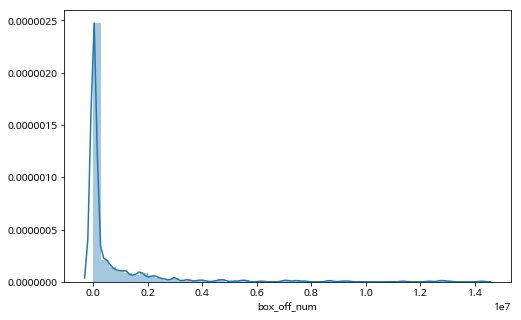

In [6]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.distplot(train['box_off_num'], ax=ax)

왼쪽으로 많이 치우쳐 오른쪽으로 꼬리가 긴 분포를 가지는 것을 확인이 가능하다. 이 변수를 그대로 학습시키기에는 데이터가 편향되어있어 정규분포에 가깝게 변환이 필요해 보인다.

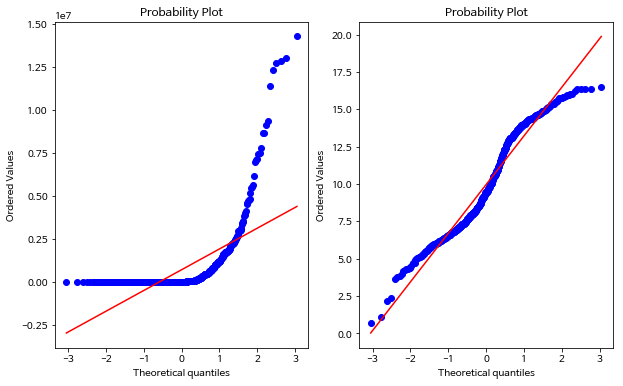

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,6))
stats.probplot(x=train['box_off_num'], plot = axes[0])
stats.probplot(x=np.log1p(train['box_off_num']), plot = axes[1])
plt.show()

로그를 취하니 정규 분포에 가까워지는 것을 확인이 가능하다. 다시 히스토그램을 그려 확인해보자.

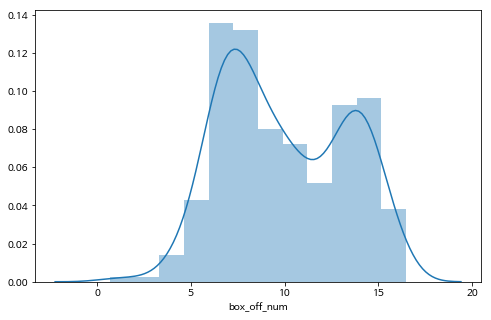

In [8]:
fig, ax = plt.subplots(figsize=(8,5))
sns.distplot(np.log1p(train['box_off_num']), ax=ax)

히스토그램을 보니 쌍봉 분포를 띄고있다. 이는 해당 목적변수 안에 서로 다른 특징을 가지는 두개의 집단으로 나뉜다는 것을 의미하는데, 조금 더 탐색의 여지가 있어보인다.<br>
이제 목적변수를 로그함수로 재표현 해주도록 하자!

In [9]:
# 정규분포에 가깝게 목적변수(관객 수) 변형(재표현)
train['box_off_num'] = np.log1p(train['box_off_num'])

In [10]:
# Skewness and kurtosis
print('Skewness :', train['box_off_num'].skew())
print('Kurtosis :', train['box_off_num'].kurt())

Skewness : 0.13382333522771098
Kurtosis : -1.0502133448839133


### 1.2 변수 시각화
* 설명 변수들과 반응 변수(관객 수)간의 상관계수를 확인하기 전에
* 범주형 변수들을 텍스트에서 숫자로 차례로 변형시켜 주자.
* 범주형 변수 : distributor(배급사), genre(장르), screening_rat(상영등급), director(감독), dir_prev_num(해당 영화의 감독이 이 영화를 만들기 전 제작에 참여한 영화의 갯수)

In [11]:
# 레이블링하는데 필요한 인코딩 라이브러리
from sklearn.preprocessing import LabelEncoder
# 유니크 개수 확인하기 위해 시각화 라이브러리
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

In [12]:
train_unique = []
columns = ['distributor', 'genre', 'screening_rat', 'director', 'dir_prev_num']
all_data = pd.concat([train.drop(['box_off_num'], axis=1),test], axis=0)   # train, test 데이터들을 합쳐서 unique 계산
print(all_data.shape)
all_data['genre'].unique()

for i in columns:
    train_unique.append(len(all_data[i].unique()))
    
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    go.Bar(
        x=unique_train['Columns'],
        y=unique_train['Unique_value'],
        name='Unique value in Features',
        textfont = dict(size=20),
        marker= dict(opacity=0.45)
    )
]

layout = go.Layout(
    title = 'Unique Value by Column',
    xaxis = dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
    yaxis = dict(title='Value Count', ticklen=5, gridwidth=2),
    showlegend = True
)

fig = go.Figure(data=data, layout=layout)
py.offline.plot(fig)

(843, 11)


'file:///Users/gim-yunsu/PycharmProjects/KagglePractice/Dacon_movie_competition/scripts/temp-plot.html'

* 장르와 상영등급, 해당 감독이 이 영화 전에 참여한 영화 갯수는 각각 12개와 4개, 7개로 완전한 범주형이다.
* 그러나 배급사와 감독은 각 100개가 넘는 unique 갯수로 범주형이라고 하기엔 조금 애매하다.
* 일단 확실한 범주형 변수인 장르와 상영등급은 sklearn의 LabelEncoder로 인코딩 해주도록 하자.

In [13]:
genre_encoder = LabelEncoder()
screen_rat_encoder = LabelEncoder()
prev_num_encoder = LabelEncoder()

# 각 범주에 맞게 피팅시켜준다.
genre_encoder.fit(all_data['genre'])
screen_rat_encoder.fit(all_data['screening_rat'])
prev_num_encoder.fit(all_data['dir_prev_num'])

# 변형시켜 준다
datas = [train, test]
for data in datas:
    data['genre'] = genre_encoder.transform(data['genre'])
    data['screening_rat'] = screen_rat_encoder.transform(data['screening_rat'])
    data['dir_prev_num'] = prev_num_encoder.transform(data['dir_prev_num'])

In [14]:
train['genre'].unique()

array([10,  2, 11,  3,  6,  4,  5,  1,  8,  9,  7,  0])

In [15]:
train['screening_rat'].unique()

array([3, 1, 2, 0])

In [16]:
train['dir_prev_num'].unique()

array([0, 2, 4, 1, 3, 5])

위와 같이 각각 컴퓨터가 알아볼 수 있게 숫자로 변형된 것을 확인할 수 있다.<br>
이제 변수들간의 상관계수를 확인해 보도록 하자.

* 피어슨 상관관계 : 연속형 변수에 사용
* 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용<br>
목적변수인 관객수와 상관관계가 높은 순서대로 스피어만 상관계수를 본 히트맵을 그려보자

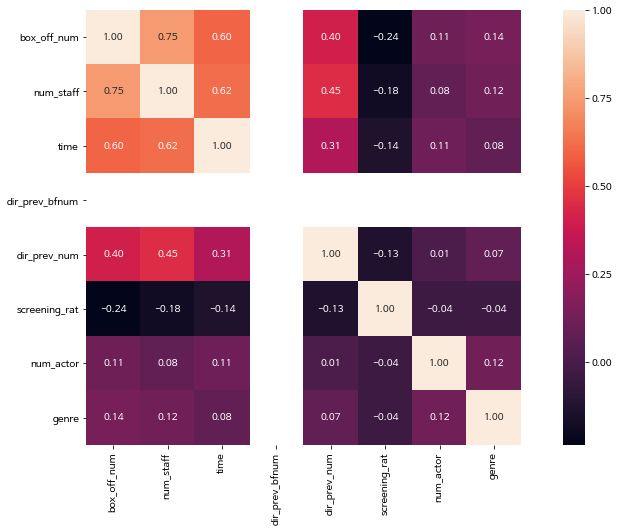

In [17]:
# box_off_num correlation matrix
corrmat = abs(train.corr(method='spearman')) # 전체 변수에 대해 correlation 계산
cols = corrmat.nlargest(n=12,columns='box_off_num').index # nlargest : return this many descending sorted values
cm = np.corrcoef(train[cols].values.T)

fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.heatmap(data=cm, cbar=True, square=True, annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values, ax=ax)

df_prev_bfnum 피처에는 NaN 값이 많이 하얗게 빈값이 많이 나온다. 이는 수정 후 다시 확인이 필요해 보인다.

#### 1.2.1 장르(genre)

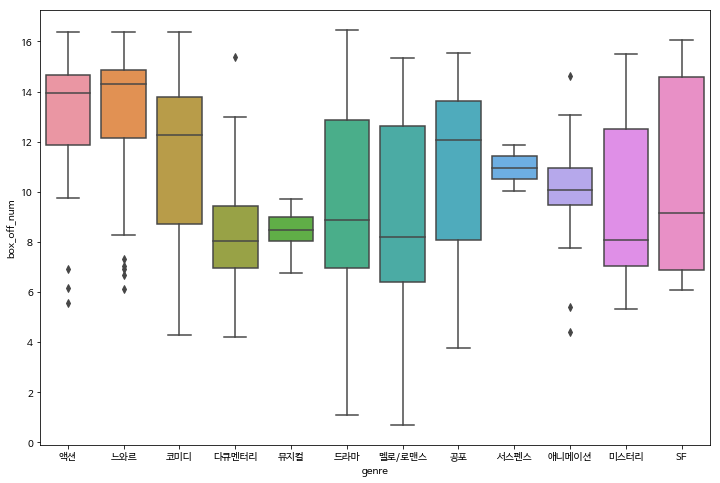

In [18]:
data = train.copy()
data['genre'] = genre_encoder.inverse_transform(data['genre'])
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(x='genre', y='box_off_num', data=data, ax=ax)

* 액션과 느와르, 코미디는 관객수가 높은쪽으로 분포한다. 대체적으로 잘 팔리는 장르로 볼 수 있겠고, 이상치를 제외하고 재미가없어도 비교적 높은 관객수는 유지되는 장르라고 볼 수 있겠다.
* 뮤지컬과 서스펜스와 같은 장르는 관객수의 분포가 굉장히 좁은 걸로 보아 매니아들만 관람하는 듯한 경향이 보인다.
* 드라마와 멜로/로맨스와 같은 장르는 대체적으로는 중간정도의 관객수를 내지만 성공과 실패시 관객수의 폭이 극단적인 경향이 있다.
* 액션, 느와르, 다큐멘터리, 애니메이션 장르에 이상치가 있는데, 이는 직접 관측이 필요해 보인다.

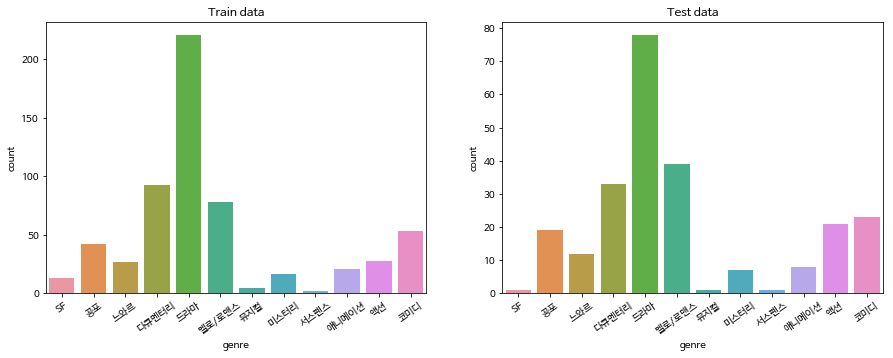

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data=train, x='genre', ax=axes[0])
axes[0].set(title='Train data')
axes[0].set_xticklabels(genre_encoder.classes_, rotation=35)
sns.countplot(data=test, x='genre', ax=axes[1])
axes[1].set(title='Test data')
axes[1].set_xticklabels(genre_encoder.classes_, rotation=35)
plt.show()

#### 1.2.2 상영등급(screening rat)

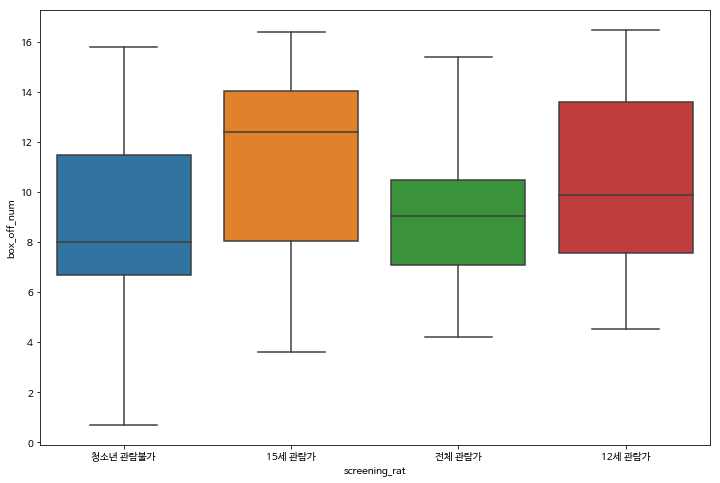

In [20]:
data = train.copy()
data['screening_rat'] = screen_rat_encoder.inverse_transform(data['screening_rat'])
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(x='screening_rat', y='box_off_num', data=data, ax=ax)

* 전체적으로 큰 차이는 없지만 12세 관람가와 15세 관람가 영화가 비교적 높은 관람객을 가지는 경향이 있다.
* 청소년 관람불가 영화와 전체 관람가 영화가 비교적 관객 수가 낮은 쪽에 몰려있는 경향이 있다.
* 이상치는 없는듯 하다.

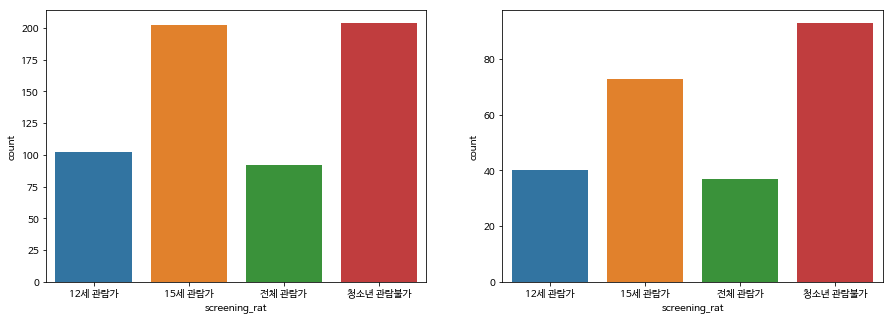

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.countplot(data=train, x='screening_rat', ax=axes[0])
axes[0].set_xticklabels(screen_rat_encoder.classes_)
sns.countplot(data=test, x='screening_rat', ax=axes[1])
axes[1].set_xticklabels(screen_rat_encoder.classes_)
plt.show()

#### 1.2.3 상영시간(time)

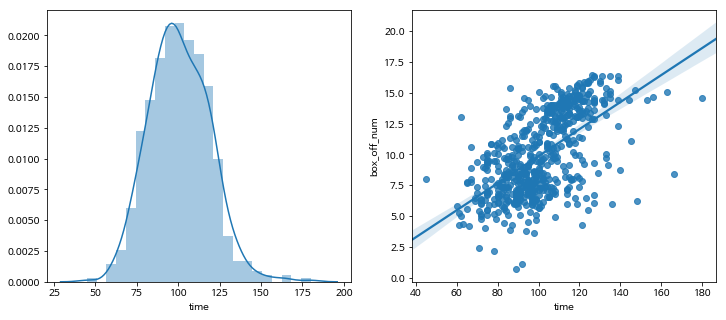

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
sns.distplot(a=train['time'], ax=axes[0])
sns.regplot(data=train, x='time', y='box_off_num', ax=axes[1])

* 상영시간 데이터의 분포도 편향되어있지 않고, 대체적으로 선형성을 띄고 있다.

Text(0.5, 1.0, '상영시간 데이터의 BoxPlot')

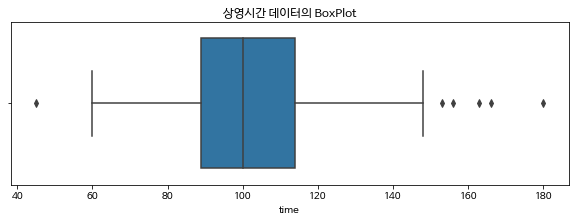

In [23]:
fig = plt.figure(figsize=(10,3))
sns.boxplot(data=train, x='time')
plt.title('상영시간 데이터의 BoxPlot')

이상치가 6개 정도 보이는데, 이는 더욱 조사가 필요해 보인다.

#### 1.2.4 dir_prev_bfnum
* 해당 영화의 감독이 전 제작에 참여한 영화에서의 평균 관객수
* 이 피처에는 NaN 값이 많았기 때문에 먼저 확인을 해보도록 하자

True     330
False    270
Name: dir_prev_bfnum, dtype: int64

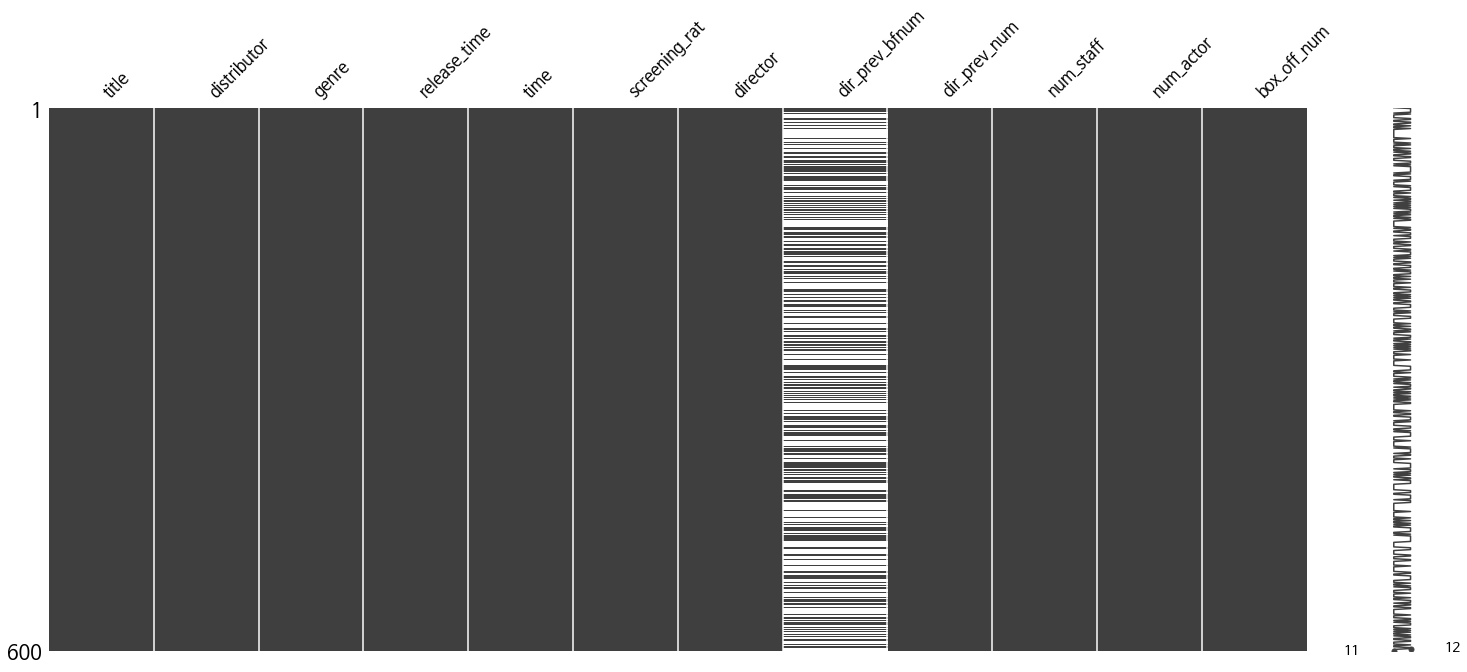

In [24]:
import missingno as msno
msno.matrix(train)
train['dir_prev_bfnum'].isnull().value_counts()

True     136
False    107
Name: dir_prev_bfnum, dtype: int64

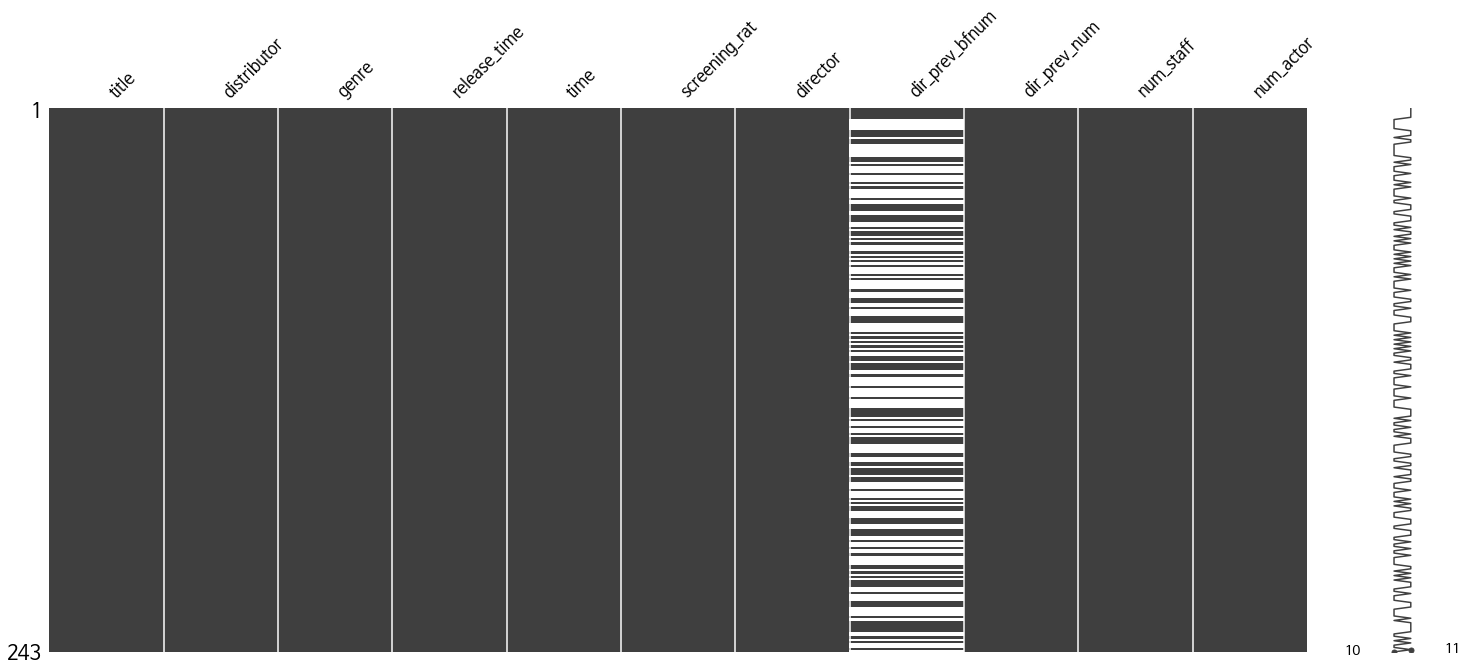

In [25]:
msno.matrix(test)
test['dir_prev_bfnum'].isnull().value_counts()

다행히도 다른 곳에는 missing 데이터가 없는 듯 하다.

In [26]:
# 비어있는 값이 없는 데이터만 확인해 보도록 하자.
ex_data_tr = train[train['dir_prev_bfnum'].notnull()]
ex_data_te = test[test['dir_prev_bfnum'].notnull()]
ex_data_tr.shape, ex_data_te.shape

((270, 12), (107, 11))

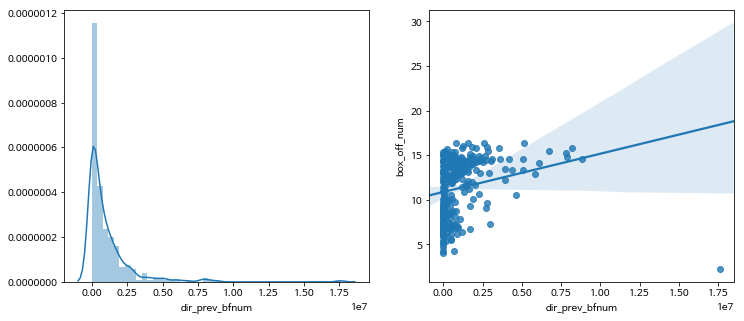

In [27]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5))
sns.distplot(a=ex_data_tr['dir_prev_bfnum'], ax=axes[0])
sns.regplot(data=ex_data_tr, x='dir_prev_bfnum', y='box_off_num', ax=axes[1])

* NaN 값이 없는 데이터만 확인해 본 결과 전체적으로 왼쪽으로 치우친 경향이 있다.
* 또한 이상치가 하나 보인다. 나중에 확인이 필요하다.

[Text(0.5, 1.0, 'Test data')]

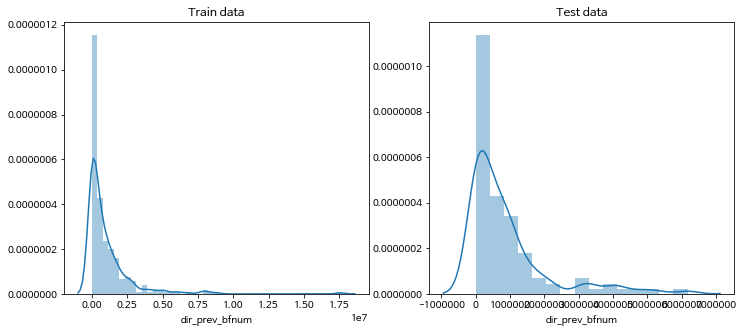

In [28]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.distplot(a=ex_data_tr['dir_prev_bfnum'], ax=axes[0])
axes[0].set(title='Train data')
sns.distplot(a=ex_data_te['dir_prev_bfnum'], ax=axes[1])
axes[1].set(title='Test data')

* 훈련데이터와 시험 데이터의 분포에 큰 차이는 없어 보인다.
* 둘 다 데이터가 왼쪽으로 치우쳐 오른쪽으로 꼬리가 긴 분포를 이루고 있으니 학습을 위해 변형이 따로 필요해 보인다.

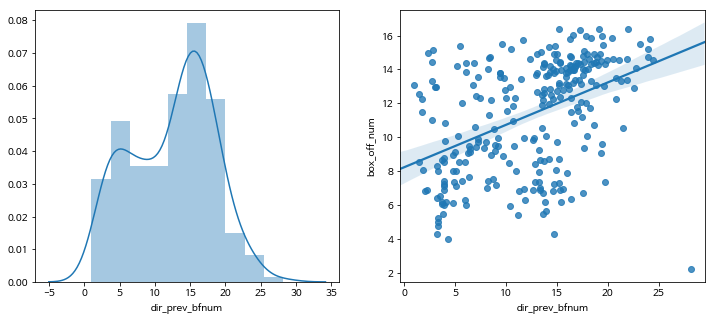

In [29]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
data = ex_data_tr.copy()
data['dir_prev_bfnum'] = np.power(data['dir_prev_bfnum'], 1/5)
sns.distplot(a=data['dir_prev_bfnum'], ax=axes[0])
sns.regplot(data=data, x='dir_prev_bfnum', y='box_off_num', ax=axes[1])

* 확인해 보니 1/5승을 한것이 가장 정규분포에 가까워 보인다.

* 이제 비어있는 데이터들을 채워주도록 하자.

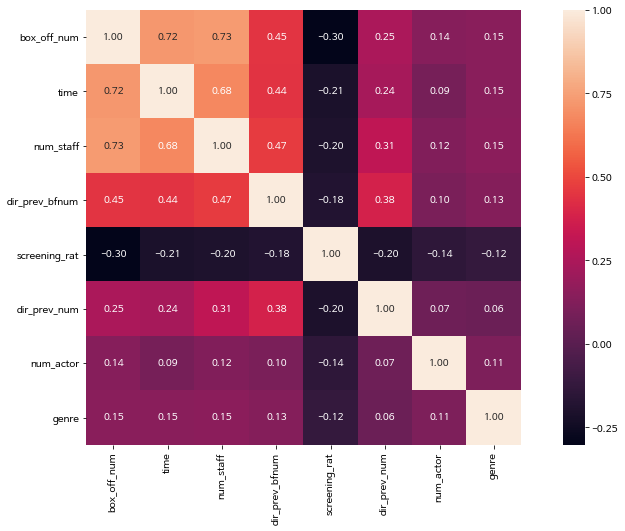

In [30]:
# box_off_num correlation matrix
corrmat = abs(data.corr(method='spearman')) # 전체 변수에 대해 correlation 계산
cols = corrmat.nlargest(n=12,columns='box_off_num').index # nlargest : return this many descending sorted values
cm = np.corrcoef(data[cols].values.T)

fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.heatmap(data=cm, cbar=True, square=True, annot=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values, ax=ax)

* 빈 데이터를 채워넣되 그 피처 고유의 특징은 변형되지 않아야 한다.(다른 변수와의 상관관계, 분포 등)

In [31]:
train[train['dir_prev_bfnum'].isnull()]['dir_prev_num'].value_counts()

0    330
Name: dir_prev_num, dtype: int64

자세히 보니 dir_prev_bfnum이 NaN인 데이터들을 dir_prev_num이 0인 즉, **전작이 없는 감독**인 셈이다. 따라서 NaN값들을 전부 0으로 채워주도록 하자.

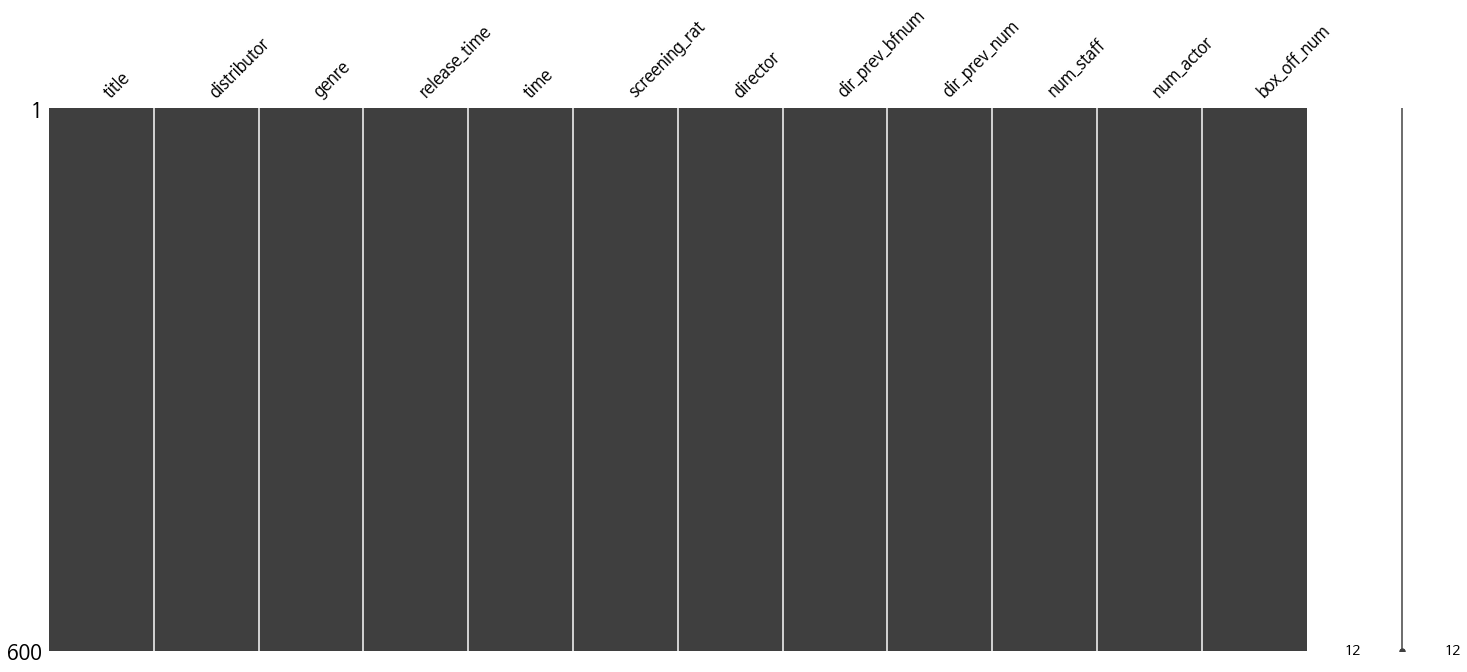

In [32]:
train['dir_prev_bfnum']= train['dir_prev_bfnum'].fillna(0)
msno.matrix(train)

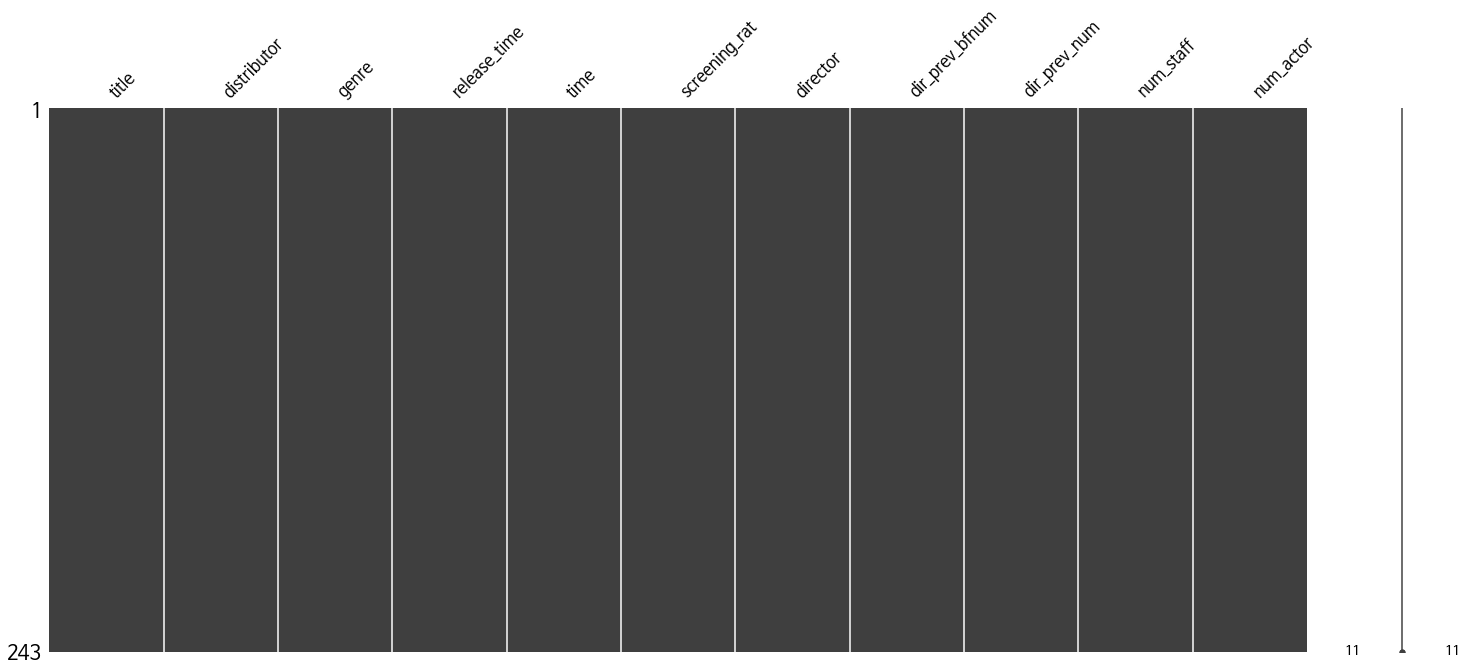

In [33]:
test['dir_prev_bfnum'] = test['dir_prev_bfnum'].fillna(0)
msno.matrix(test)

전부 채워졌다.

#### 1.2.5 dir_prev_num
* 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수

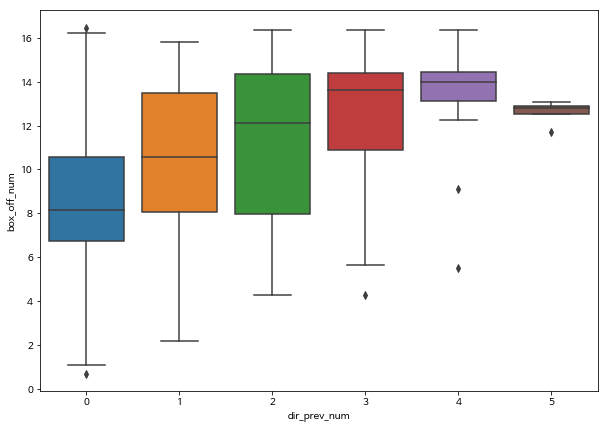

In [34]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.boxplot(data=train, x='dir_prev_num', y='box_off_num', ax=ax)

몇몇 이상치는 보이지만 전작의 수가 많은 영화일수록 관람객의 수가 높은 경향이 있다.

#### 1.2.6 스텝수(num_staff)

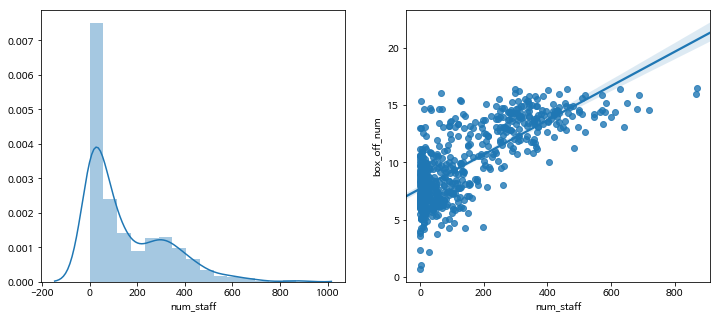

In [35]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.distplot(a=train['num_staff'], ax=axes[0])
sns.regplot(data=train, x='num_staff', y='box_off_num', ax=axes[1])

* 대체로 선형성을 띄고 있지만 데이터의 분포가 왼쪽으로 치우친 경향이 있다.

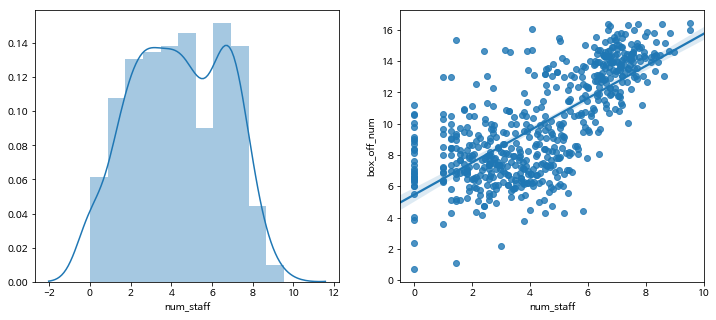

In [36]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
data = train.copy()
data['num_staff'] = np.power(data['num_staff'], 1/3)
sns.distplot(a=data['num_staff'], ax=axes[0])
sns.regplot(data=data, x='num_staff', y='box_off_num', ax=axes[1])

* 데이터에 1/3승을 하니 정규분포의 모양을 띈다.

Text(0.5, 1.0, '스텝 수의 BoxPlot')

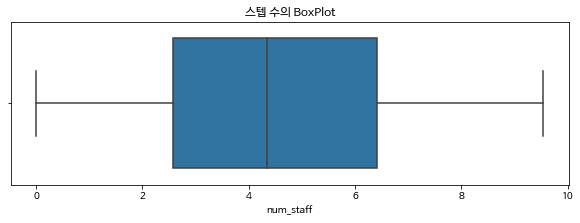

In [37]:
fig = plt.figure(figsize=(10,3))
sns.boxplot(data=data, x='num_staff')  # 1/3승으로 변형을 한 데이터를 사용한다.
plt.title('스텝 수의 BoxPlot')

이상치는 없어보인다.

#### 1.2.7 배우의 수(num_actor)

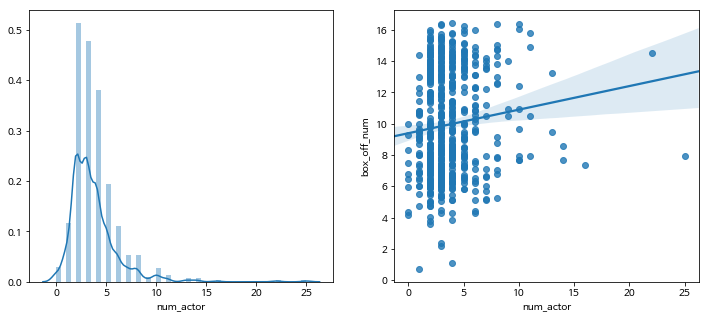

In [38]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
sns.distplot(a=train['num_actor'], ax=axes[0])
sns.regplot(data=train, x='num_actor', y='box_off_num', ax=axes[1])

Text(0.5, 1.0, '배우의 수의 BoxPlot')

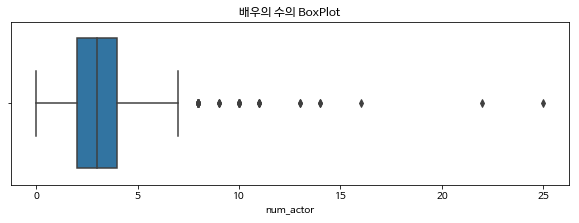

In [39]:
fig = plt.figure(figsize=(10,3))
sns.boxplot(x=train['num_actor'])
plt.title('배우의 수의 BoxPlot')

대체로 선형성을 띄고 있고 분포도 크게 손볼곳이 없어 보인다. 하지만 몇몇의 이상치가 있으니 확인이 필요해 보인다.

## 2. Feature engineering
* 이제 살펴본 내용들을 바탕으로 특징들을 가공해 보자.

### 2.1 정규화
* 앞서 보았던 편향된 데이터들을 정규분포에 근사하게 정규화 해주자

In [40]:
data = [train, test]
# 해당 영화 감독의 전작들의 평균 관객수 : 1/5
for d in data:
    d['dir_prev_bfnum'] = np.power(d['dir_prev_bfnum'], 1/5)

In [41]:
# 스텝 수 : 1/3
for d in data:
    d['num_staff'] = np.power(d['num_staff'], 1/3)

In [42]:
for d in data:
    d['time'] = np.log1p(d['time'])

### 2.2 이상치(Outlier)
피처들을 탐색하며 확인했던 이상치들을 차례로 살펴보고 비정상적인 데이터는 삭제해 주도록 하자.
#### 2.2.1 장르(genre)

In [43]:
genre_encoder.classes_

array(['SF', '공포', '느와르', '다큐멘터리', '드라마', '멜로/로맨스', '뮤지컬', '미스터리', '서스펜스',
       '애니메이션', '액션', '코미디'], dtype=object)

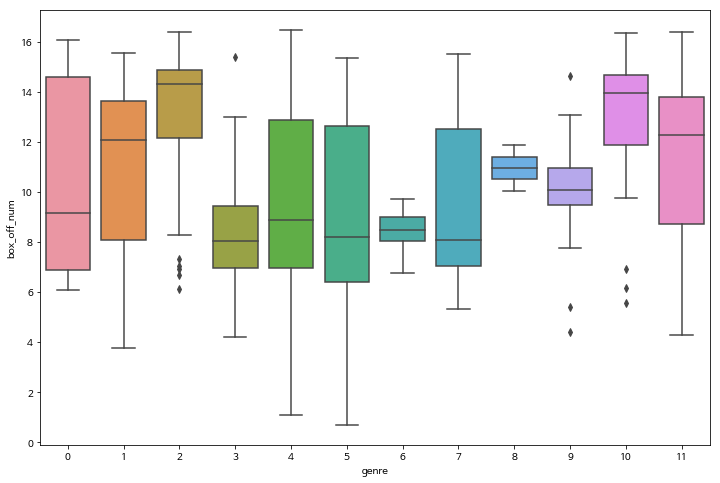

In [44]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.boxplot(x='genre', y='box_off_num', data=train, ax=ax)

In [45]:
# 액션 영화
train[(train['genre'] == 10) & (train['box_off_num'] < 8)]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
188,권법형사 : 차이나타운,골든타이드픽처스,10,2015-07-09,4.430817,3,박상현,0.000000,0,5.325074,2,5.552960
248,철암 계곡의 혈투,인디스토리,10,2012-07-12,4.499810,3,지하진,0.000000,0,1.709976,2,6.910751
424,짐승,(주)키노아이,10,2011-07-28,4.543295,3,황유식,13.832542,2,3.779763,2,6.175867


... 잘못된 것은 없어보인다.

In [46]:
# 다큐맨터리
train[(train['genre'] == 3) & (train['box_off_num'] > 14)]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
267,"님아, 그 강을 건너지 마오",CGV아트하우스,3,2014-11-27,4.465908,2,진모영,5.515681,1,1.44225,2,15.384578


In [47]:
# 느와르
train[(train['genre'] == 2) & (train['box_off_num'] < 8)]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
175,악인은 너무 많다,어뮤즈,2,2011-12-15,4.330733,3,김회근,17.584996,2,2.962496,4,6.697034
198,18: 우리들의 성장 느와르,어뮤즈,2,2014-08-14,4.653960,3,한윤선,8.122187,1,5.013298,3,7.025538
239,개: dog eat dog,어썸 피플,2,2015-03-05,4.624973,3,황욱,0.000000,0,3.870877,5,7.316548
519,보호자,무비꼴라쥬,2,2014-04-10,4.488636,1,유원상,4.780231,1,5.039684,3,6.129050
524,코인라커,(주)드림팩트엔터테인먼트,2,2015-05-28,4.564348,3,김태경,11.795966,1,4.862944,2,6.916715


In [48]:
# 애니메이션
train[(train['genre'] == 9) & (train['box_off_num'] < 6)]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
312,집,CJ 엔터테인먼트,9,2011-03-17,4.430817,1,박미선,0.0,0,5.828477,6,4.406719
416,은실이,CJ 엔터테인먼트,9,2012-03-08,4.276666,3,김선아,0.0,0,2.571282,3,5.389072


이렇게 이상치들을 확인해보니 인지도가 없음에도 불구하고 비정상적으로 관람객수가 높거나 매우 유명한 영화임에도 불구하고 이상하게 낮은 데이터는 없어 보인다.

#### 2.2.2 dir_prev_bfnum

In [49]:
train[train['dir_prev_bfnum'] > 25]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
338,타부 : 금지된 사랑,고구마공작소,5,2015-09-03,4.369448,3,고구마,28.130541,1,3.0,3,2.197225


고구마라는 감독을 찾아본 결과 천만영화인 명량의 메이킹 제작진으로 되어있으나 본인이 직접 감독을 한 것이 아니므로 이상한 값으로 간주하고 삭제하도록 하겠다.

In [50]:
train = train[train['dir_prev_bfnum'] < 25]

#### 2.2.3 배우의 수(num_actor)

In [51]:
train[train['num_actor'] == 0]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
107,미국의 바람과 불,시네마 달,3,2012-07-26,4.779123,1,김경만,0.0,0,1.817121,0,6.481577
167,모래가 흐르는 강,시네마 달,3,2013-03-28,4.330733,2,지율스님,0.0,0,2.223980,0,9.300455
168,망대,골든타이드픽처스,3,2015-03-12,4.204693,2,문승욱,0.0,0,2.351335,0,4.189655
355,오디세오,(주)패뷸러스,6,2015-10-22,4.394449,2,정성복,0.0,0,0.000000,0,6.760415
391,명령불복종 교사,인디플러그,3,2015-05-14,4.574711,2,서동일,0.0,0,1.442250,0,7.510978
418,오월愛,상구네 필름,3,2011-05-12,4.653960,2,김태일,0.0,0,1.587401,0,8.317033
425,보라,시네마달,3,2011-11-24,4.919981,2,이강현,0.0,0,1.912931,0,5.966147
437,나쁜 나라,(주)시네마달,3,2015-12-03,4.795791,0,김진열,0.0,0,1.259921,0,9.979383
456,"60년전, 사선에서",인터콘미디어,3,2010-06-24,4.158883,2,박성미,0.0,0,2.154435,0,4.382027


배우의 수가 0인 영화는 말그대로 배우 없이 감독이 직접 다니며 찍은 영화를 말하며 주로 다큐멘터리인 경우가 많다. 이상해 보이는 데이터는 보이지 않는다.

In [52]:
train[train['num_actor'] > 20]

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
80,바비,(주) 케이알씨지,4,2010-02-04,4.762174,1,에밀리오 에스테베즈,0.000000,0,2.668402,25,7.945201
486,뷰티 인사이드,(주)NEW,5,2015-08-20,4.852030,0,백종열,21.128798,3,8.301031,22,14.537195


배우의 수가 20명이 넘는 경우도 잘못되어 보이는 데이터는 없다.

### 2.3 변수 재표현 및 생성
* 앞서 존재하는 피처들을 바탕으로 새로운 특징을 생성하거나 변형을 시켜보자

#### 2.3.1 release_time
release_time 은 문자열 형태로 그대로 사용할 수는 없으니 연도(year)랑 월(month)은 따로 숫자로 나누어주고 일(day)데이터는 버리도록 하자.

In [53]:
train['year'] = train['release_time'].apply(lambda x : int(x[:4]))
train['month'] = train['release_time'].apply(lambda x : int(x[5:7]))

In [54]:
test['year'] = test['release_time'].apply(lambda x : int(x[:4]))
test['month'] = test['release_time'].apply(lambda x : int(x[5:7]))

In [55]:
year_encoder = LabelEncoder().fit(train['year'])
train['year'] = year_encoder.transform(train['year'])
test['year'] = year_encoder.transform(test['year'])

In [56]:
# release_time은 이제 필요가 없으니 버린다.
train.drop(['release_time'], axis=1, inplace=True)

In [57]:
test.drop(['release_time'], axis=1, inplace=True)

#### 2.3.2 흥행보장 감독
상위 5%안에 드는 관객수를 가진 영화의 감독을 뽑아내보자

In [58]:
# 관객 수 상위 5% 값
g_score = np.percentile(train['box_off_num'].values, 95)

In [59]:
# 상위 5% 영화 정보
train[train['box_off_num'] > g_score]

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month
1,내부자들,(주)쇼박스,2,4.875197,3,우민호,16.330952,2,7.287362,3,15.771725,5,11
2,은밀하게 위대하게,(주)쇼박스,10,4.820282,1,장철수,11.716289,4,7.000000,4,15.755558,3,6
16,써니,CJ E&M Pictures,11,4.828314,1,강형철,24.155146,1,8.301031,11,15.824223,1,5
74,아저씨,CJ 엔터테인먼트,10,4.787492,3,이정범,0.000000,0,7.984344,2,15.636613,0,8
101,관상,(주)쇼박스,4,4.941642,1,한재림,16.553076,2,6.679420,6,16.027712,3,9
112,범죄와의 전쟁: 나쁜놈들 전성시대,(주)쇼박스,2,4.897840,3,윤종빈,14.839411,1,6.753313,2,15.367330,2,2
122,변호인,(주)NEW,4,4.852030,1,양우석,0.000000,0,6.775169,5,16.246918,3,12
124,역린,롯데엔터테인먼트,4,4.912655,1,이재규,2.888279,1,8.662391,5,15.163505,4,4
128,조선명탐정 : 각시투구꽃의 비밀,쇼박스(주)미디어플렉스,11,4.753590,0,김석윤,0.000000,0,6.945150,3,15.381260,1,1
178,조선명탐정 : 사라진 놉의 딸,(주)쇼박스,11,4.836282,0,김석윤,0.000000,0,7.697002,3,15.169286,5,2


상위 5%의 성적을 낸 영화는 30개 정도가 있는데 이 영화의 감독들은 흥행보장 감독이라고 가정하고<br><br>
**흥행보장 감독 : 1**<br>
**그 외 : 0**    <br><Br>으로 매핑을 시켜주자

In [60]:
# 상위 5% 영화 정보
data = train[train['box_off_num'] > g_score]
g_score_dir_list = list(data['director'].unique())

In [61]:
# 흥행보장 감독 : 1
# 그 외 : 0   으로 매핑
train['g_score_dir'] = train['director'].apply(lambda x : 1 if x in g_score_dir_list else 0)
test['g_score_dir'] = test['director'].apply(lambda x : 1 if x in g_score_dir_list else 0)

#### 2.3.3 거대 배급사
배급사는 상영관의 수를 결정해 주기 때문에 자본이 큰 거대 배급사의 경우 영화 관람객 수에 좋은 영향을 미칠 수 있다.

In [62]:
# 관객 수 상위 10% 값
g_score = np.percentile(train['box_off_num'].values, 90)

In [63]:
train[train['box_off_num'] > g_score]['distributor'].unique()

array(['(주)쇼박스', 'CJ E&M Pictures', 'CJ 엔터테인먼트', '롯데엔터테인먼트', '(주)NEW',
       '인벤트 디', '영구아트무비', '쇼박스(주)미디어플렉스', 'CJ E&M 영화부문', '싸이더스', '시네마서비스',
       'CGV아트하우스', '(주)아이필름코퍼레이션', 'NEW', '씨네그루(주)키다리이엔티', '필라멘트 픽쳐스',
       '이십세기폭스코리아(주)'], dtype=object)

In [64]:
train['distributor'].value_counts().apply(lambda x : x if x>2 else np.NAN).dropna()

CJ 엔터테인먼트        54.0
롯데엔터테인먼트         52.0
(주)NEW           30.0
(주)마운틴픽쳐스        29.0
인디스토리            26.0
(주)쇼박스           26.0
골든타이드픽처스         15.0
(주) 케이알씨지        14.0
시너지              10.0
시네마달             10.0
(주) 영화사조제        10.0
(주)키노아이          10.0
영화사 진진           10.0
어뮤즈              10.0
인디플러그             9.0
KT&G 상상마당         8.0
NEW               8.0
인벤트 디             8.0
스폰지               7.0
BoXoo 엔터테인먼트      6.0
시네마 달             6.0
(주)팝엔터테인먼트        6.0
무비꼴라쥬             6.0
시네마서비스            6.0
필라멘트 픽쳐스          6.0
리틀빅픽처스            5.0
CGV아트하우스          5.0
홀리가든              4.0
마노엔터테인먼트          4.0
메가박스(주)플러스엠       4.0
나이너스엔터테인먼트(주)     4.0
(주)엣나인필름          4.0
씨너스엔터테인먼트(주)      4.0
드림팩트 엔터테인먼트       3.0
싸이더스              3.0
마운틴 픽처스           3.0
김기덕 필름            3.0
KT                3.0
트리필름              3.0
(주) 브릿지웍스         3.0
이모션 픽처스           3.0
씨네그루(주)키다리이엔티     3.0
(주)마인스 엔터테인먼트     3.0
이십세기폭스코리아(주)      3.0
CJ E&M 영화부문       3.0
타임스토리그룹   

투자한 영화 중에 상위 10%안에드는 영화가 있고, 배급하는 영화의 갯수도 많은 영화들을 위주로 매핑해주고, 그외는 전부 0으로 매핑시켜주도록 하자.<br>
또한 CJ와 쇼박스는 같은 배급사임에도 여러가지 이름으로 되어있기 때문에 합쳐주는 작업이 필요해 보인다.

In [65]:
# 배급사 이름 안에 CJ와 쇼박스가 들어있으면 통일시켜준다.
def merge_distributor(x):
    if 'CJ' in x: return 'CJ 엔터테인먼트'
    elif '쇼박스' in x: return '(주)쇼박스'
    else: return x

In [66]:
train['distributor'] = train['distributor'].apply(merge_distributor)

In [67]:
test['distributor'] = test['distributor'].apply(merge_distributor)

In [68]:
g_score_mov = {'CJ 엔터테인먼트' : 1,
               '롯데엔터테인먼트' : 2,
               '(주)NEW' : 3,
               'CGV아트하우스' : 4,
               'NEW' : 5,
               '필라멘트 픽쳐스' :6 ,
               '이십세기폭스코리아(주)' : 7,
              '(주)쇼박스' : 8}

매핑하는 숫자가 너무 크면 다른 특징에 비해 비중이 너무 커질수도 있으니 0.5 간격으로 매핑해 주었고, 나머지 배급사 영화는 0으로 매핑하도록 하자.

In [69]:
train['distributor'] = train['distributor'].map(g_score_mov).fillna(0)

In [70]:
test['distributor'] = test['distributor'].map(g_score_mov).fillna(0)

올바르게 변형되었는지 확이해 보도록 하자

In [71]:
train['distributor'].unique()

array([2., 8., 3., 0., 1., 4., 5., 6., 7.])

In [72]:
test['distributor'].unique()

array([0., 8., 1., 2., 5., 6., 3., 7., 4.])

In [73]:
train.head()

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,g_score_dir
0,개들의 전쟁,2.0,10,4.574711,3,조병옥,0.000000,0,4.497941,2,10.060449,2,11,0
1,내부자들,8.0,2,4.875197,3,우민호,16.330952,2,7.287362,3,15.771725,5,11,1
2,은밀하게 위대하게,8.0,10,4.820282,1,장철수,11.716289,4,7.000000,4,15.755558,3,6,1
3,나는 공무원이다,3.0,11,4.624973,2,구자홍,7.510308,2,2.714418,6,12.291640,2,7,0
4,불량남녀,8.0,11,4.691348,1,신근호,1.000000,1,6.307994,2,13.088575,0,11,0


In [74]:
test.head()

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,year,month,g_score_dir
0,용서는 없다,0.0,2,4.836282,3,김형준,12.461700,2,6.723951,3,0,1,0
1,아빠가 여자를 좋아해,8.0,5,4.736198,0,이광재,12.793309,4,6.502957,3,0,1,0
2,하모니,1.0,4,4.753590,0,강대규,21.124501,3,7.482924,7,0,1,0
3,의형제,8.0,10,4.762174,1,장훈,14.721043,2,7.416860,2,0,2,0
4,평행 이론,1.0,1,4.709530,1,권호영,7.949062,1,7.243156,1,0,2,0


In [75]:
len(train.columns), len(test.columns)

(14, 13)

## 3. 모델링
* 이제 모델에 입력데이터로 사용할 데이터들이 준비되었다. 본격적으로 모델링에 들어가 보도록 하자.

In [76]:
# 모델링에 집어넣을 데이터 준비
train_label = train['box_off_num']
train_data = train.drop(['title','director', 'box_off_num'], axis=1)
test_data = test.drop(['title','director'], axis=1)

In [77]:
train_data.shape, test_data.shape

((599, 11), (243, 11))

In [78]:
train.head()

,title,distributor,genre,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,year,month,g_score_dir
0,개들의 전쟁,2.0,10,4.574711,3,조병옥,0.000000,0,4.497941,2,10.060449,2,11,0
1,내부자들,8.0,2,4.875197,3,우민호,16.330952,2,7.287362,3,15.771725,5,11,1
2,은밀하게 위대하게,8.0,10,4.820282,1,장철수,11.716289,4,7.000000,4,15.755558,3,6,1
3,나는 공무원이다,3.0,11,4.624973,2,구자홍,7.510308,2,2.714418,6,12.291640,2,7,0
4,불량남녀,8.0,11,4.691348,1,신근호,1.000000,1,6.307994,2,13.088575,0,11,0


In [79]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb

In [80]:
kfolds = KFold(n_splits=5, random_state=2019, shuffle=True)

# 교차 검증을 위해
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(estimator=model, X=train_data, y=train_label, scoring='neg_mean_squared_error', cv=kfolds))
    return rmse

### 3.1 Ridge

In [81]:
def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(), RidgeCV(alphas=[k], cv=kfolds)).fit(train_data, train_label)
    ridge_rmse = cv_rmse(ridge_model).mean()
    return ridge_rmse

r_alphas = [0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.20, 1.25, 1.30, 1.35, 1.40, 1.45, 1.50, 1.55, 1.60]

In [82]:
ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

/Users/gim-yunsu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/gim-yunsu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/gim-yunsu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.

/Users/gim-yunsu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

Th

Text(0, 0.5, 'score')

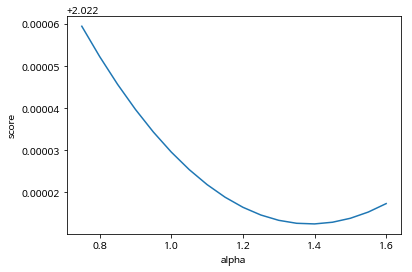

In [83]:
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.xlabel('alpha')
plt.ylabel('score')

alpha를 1.4로 했을때 제일 성능이 높게 나오는 것을 확인할 수 있다.

In [84]:
ridge_model = make_pipeline(RobustScaler(), RidgeCV(alphas=[1.4], cv=kfolds)).fit(train_data, train_label)
print(cv_rmse(ridge_model).mean())

2.0220124946204536


/Users/gim-yunsu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



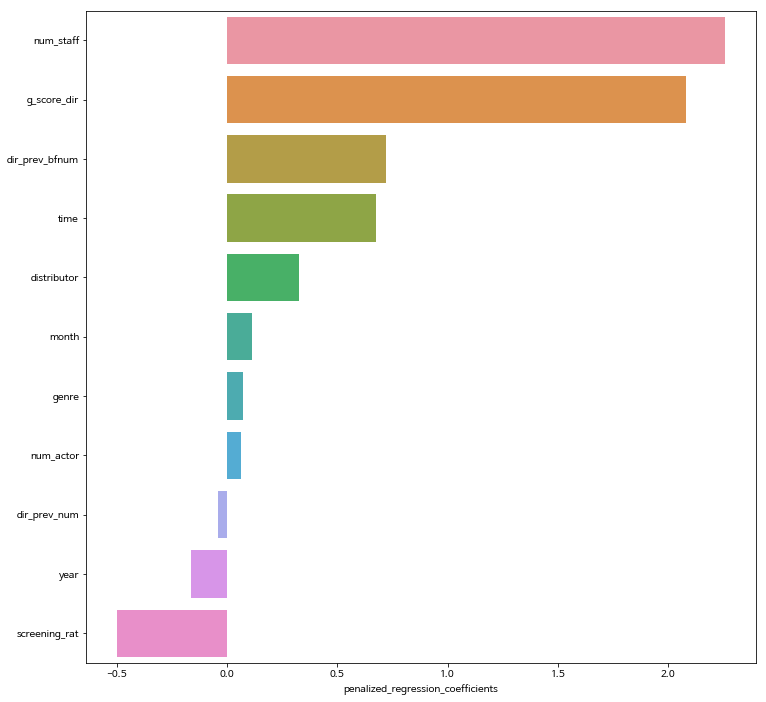

In [85]:
ridge_coef = pd.DataFrame(data=np.round(ridge_model.steps[1][1].coef_, decimals=3), index=train_data.columns, columns=['penalized_regression_coefficients'])
# sort values
ridge_coef = ridge_coef.sort_values(by='penalized_regression_coefficients', ascending=False)

# plot the sorted dataframe
fig = plt.figure(figsize=(12,12))
sns.barplot(data=ridge_coef, x='penalized_regression_coefficients', y=ridge_coef.index)

### 

### 3.2 Lasso 

In [86]:
def lasso_selector(k):
    lasso_model = make_pipeline(RobustScaler(), LassoCV(alphas=[k], cv=kfolds)).fit(train_data, train_label)
    lasso_rmse = cv_rmse(lasso_model).mean()
    return lasso_rmse

l_alphas = [0.00001, 0.00003, 0.00005, 0.00007, 0.00009, 0.0001, 0.0005, 0.001, 0.003, 0.005, 0.007, 0.009, 0.01, 0.02, 0.03]

In [87]:
lasso_scores = []
for alpha in l_alphas:
    score = lasso_selector(alpha)
    lasso_scores.append(score)

Text(0, 0.5, 'score')

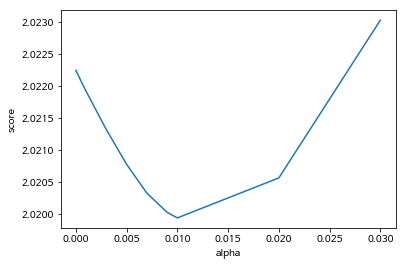

In [88]:
plt.plot(l_alphas, lasso_scores, label='Lasso')
plt.xlabel('alpha')
plt.ylabel('score')

In [89]:
lasso_model = make_pipeline(RobustScaler(), LassoCV(alphas=[0.01], cv=kfolds)).fit(train_data, train_label)
cv_rmse(lasso_model).mean()

2.019939695176518

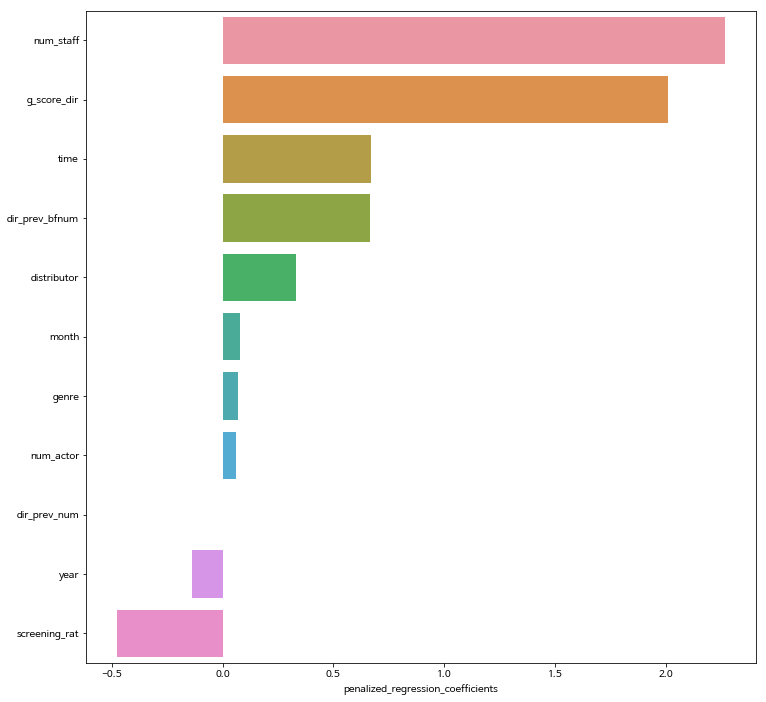

In [90]:
lasso_coef = pd.DataFrame(data=np.round(lasso_model.steps[1][1].coef_, decimals=3), index=train_data.columns, columns=['penalized_regression_coefficients'])
# sort values
lasso_coef = lasso_coef.sort_values(by='penalized_regression_coefficients', ascending=False)

# plot the sorted dataframe
fig = plt.figure(figsize=(12,12))
sns.barplot(data=lasso_coef, x='penalized_regression_coefficients', y=lasso_coef.index)

### 3.3 LightGBM

In [91]:
param = {
    'num_leaves' : 31,
    'min_data_in_leaf' : 10,
    'objective' : 'regression',
    'max_depth' : -1,
    'learning_rate' : 0.002,
    'min_child_samples' : 12,
    'boosting' : 'gbdt',
    'feature_fraction' : 0.9,
    'bagging_freq' : 1,
    'bagging_fraction' : 0.9,
    'bagging_seed' : 11,
    'metric' : 'rmse',
    'lambda_l2' : 5,
    'verbosity' : -1,
    'nthread' : -1,
    'random_state' : 2019
}

# prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=2019)
oof1 = np.zeros(len(train_data))
predictions = np.zeros(len(test_data))
feature_importance_df = pd.DataFrame()

# run model
for fold_, (trn_index, val_index) in enumerate(folds.split(train_data)):
    trn_data = lgb.Dataset(train_data.iloc[trn_index], label=train_label.iloc[trn_index])
    val_data = lgb.Dataset(train_data.iloc[val_index], label=train_label.iloc[val_index])
    
    num_round = 5000
    clf = lgb.train(params=param, train_set=trn_data, num_boost_round=num_round, valid_sets=[trn_data, val_data], verbose_eval=500, early_stopping_rounds=500)
    oof1[val_index] = clf.predict(train_data.iloc[val_index], num_iterations=clf.best_iteration) # 나중에 스태킹을 위한 train 데이터도 된다.
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = train_data.columns
    fold_importance_df['importance'] = clf.feature_importance()
    
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    # predictions
    predictions += clf.predict(test_data, num_iterations=clf.best_iteration) / folds.n_splits # 나중에 스태킹을 위한 test 데이터도 된다.
    
cv = np.sqrt(mean_squared_error(oof1, train_label))
print(cv)

Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 1.99207	valid_1's rmse: 2.21146
[1000]	training's rmse: 1.53425	valid_1's rmse: 1.80599
[1500]	training's rmse: 1.30294	valid_1's rmse: 1.70112
[2000]	training's rmse: 1.14465	valid_1's rmse: 1.66575
[2500]	training's rmse: 1.02025	valid_1's rmse: 1.65568
[3000]	training's rmse: 0.917872	valid_1's rmse: 1.65098
Early stopping, best iteration is:
[2963]	training's rmse: 0.924864	valid_1's rmse: 1.65062
Training until validation scores don't improve for 500 rounds.
[500]	training's rmse: 2.00601	valid_1's rmse: 2.10611
[1000]	training's rmse: 1.53708	valid_1's rmse: 1.80351
[1500]	training's rmse: 1.30455	valid_1's rmse: 1.72504
[2000]	training's rmse: 1.14614	valid_1's rmse: 1.69543
[2500]	training's rmse: 1.02343	valid_1's rmse: 1.69099
Early stopping, best iteration is:
[2444]	training's rmse: 1.03584	valid_1's rmse: 1.68959
Training until validation scores don't improve for 500 rounds.
[500]	trainin

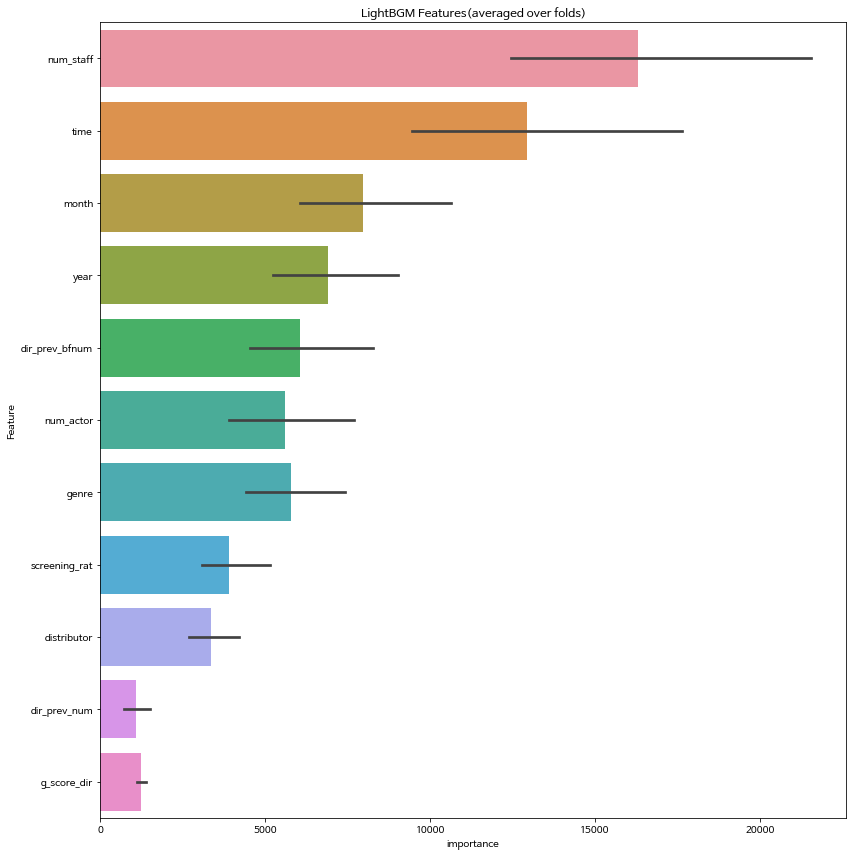

In [92]:
# plot the feature importance
cols = feature_importance_df[['Feature', 'importance']].groupby('Feature').mean().sort_values(by='importance',ascending=False)[:1000].index
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(12,12))
sns.barplot(x='importance', y='Feature', data=best_features.sort_values(by='importance',ascending=False))
plt.title('LightBGM Features(averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importaces.png')

### 3.4 XGBoost

In [93]:
params = {
    'booster' : 'gbtree',
    'max_depth': 3,
    'eta' : 0.001,
    'objective' : 'reg:linear',
    'eval_metric' : 'rmse',
    'n_thread' : -1,
    'silent' : 1,
    'lambda' : 1,
    'sub_sample' : 0.9
}

# prepare fit model with cross-validation
oof2 = np.zeros(len(train_data))
predictions2 = np.zeros((len(test_data)))
feature_importance_df2 = pd.DataFrame()

num_rounds = 5000
for folds_, (trn_index, val_index) in enumerate(folds.split(train_data)):
    trn_dmtx = xgb.DMatrix(data=train_data.iloc[trn_index].values, label=train_label.iloc[trn_index].values)
    val_dmtx = xgb.DMatrix(data=train_data.iloc[val_index].values, label=train_label.iloc[val_index].values)
    
    wlist = [(trn_dmtx, 'train'),(val_dmtx, 'eval')]
    clf = xgb.train(params=params, dtrain=trn_dmtx, num_boost_round=num_rounds, evals=wlist, verbose_eval=100, early_stopping_rounds=500)
    oof2[val_index] = clf.predict(data=val_dmtx) # 스태킹 모델링을 위해 남겨놓는다(스태킹 모델의 훈련 데이터)
    
    # 스테킹 모델의 테스트 데이터가 된다.
    predictions2 += clf.predict(data=xgb.DMatrix(data=test_data.values)) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof2, train_label))
print(cv)

[0]	train-rmse:9.96527	eval-rmse:10.207
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 500 rounds.
[100]	train-rmse:9.05864	eval-rmse:9.29112
[200]	train-rmse:8.24	eval-rmse:8.46857
[300]	train-rmse:7.50132	eval-rmse:7.72781
[400]	train-rmse:6.83549	eval-rmse:7.06026
[500]	train-rmse:6.23596	eval-rmse:6.46057
[600]	train-rmse:5.69671	eval-rmse:5.92194
[700]	train-rmse:5.21191	eval-rmse:5.43637
[800]	train-rmse:4.77643	eval-rmse:4.99052
[900]	train-rmse:4.38594	eval-rmse:4.59004
[1000]	train-rmse:4.03643	eval-rmse:4.23158
[1100]	train-rmse:3.72299	eval-rmse:3.9177
[1200]	train-rmse:3.44384	eval-rmse:3.63031
[1300]	train-rmse:3.19533	eval-rmse:3.37288
[1400]	train-rmse:2.97463	eval-rmse:3.14615
[1500]	train-rmse:2.7786	eval-rmse:2.94474
[1600]	train-rmse:2.60607	eval-rmse:2.76716
[1700]	train-rmse:2.45468	eval-rmse:2.61034
[1800]	train-rmse:2.32198	eval-rmse:2.47548
[1900]	train-rmse:2.20509	eval-rmse:2.

[2300]	train-rmse:1.8717	eval-rmse:2.00222
[2400]	train-rmse:1.8116	eval-rmse:1.95626
[2500]	train-rmse:1.75915	eval-rmse:1.91904
[2600]	train-rmse:1.71308	eval-rmse:1.8885
[2700]	train-rmse:1.67331	eval-rmse:1.86424
[2800]	train-rmse:1.63921	eval-rmse:1.84409
[2900]	train-rmse:1.61019	eval-rmse:1.82668
[3000]	train-rmse:1.5856	eval-rmse:1.81218
[3100]	train-rmse:1.56376	eval-rmse:1.80005
[3200]	train-rmse:1.54466	eval-rmse:1.79003
[3300]	train-rmse:1.52705	eval-rmse:1.78154
[3400]	train-rmse:1.51122	eval-rmse:1.77448
[3500]	train-rmse:1.49723	eval-rmse:1.7684
[3600]	train-rmse:1.48475	eval-rmse:1.76309
[3700]	train-rmse:1.47325	eval-rmse:1.75881
[3800]	train-rmse:1.46252	eval-rmse:1.75448
[3900]	train-rmse:1.45276	eval-rmse:1.7516
[4000]	train-rmse:1.44363	eval-rmse:1.7494
[4100]	train-rmse:1.43573	eval-rmse:1.74832
[4200]	train-rmse:1.42757	eval-rmse:1.74647
[4300]	train-rmse:1.41963	eval-rmse:1.74495
[4400]	train-rmse:1.41294	eval-rmse:1.7446
[4500]	train-rmse:1.40731	eval-rmse:1.74

### 3.5 RandomForest

In [94]:
rf_model = RandomForestRegressor(n_estimators=200, random_state=2019, max_depth=10, n_jobs=-1).fit(train_data, train_label)

In [95]:
print(cv_rmse(rf_model).mean())

1.755251275906963


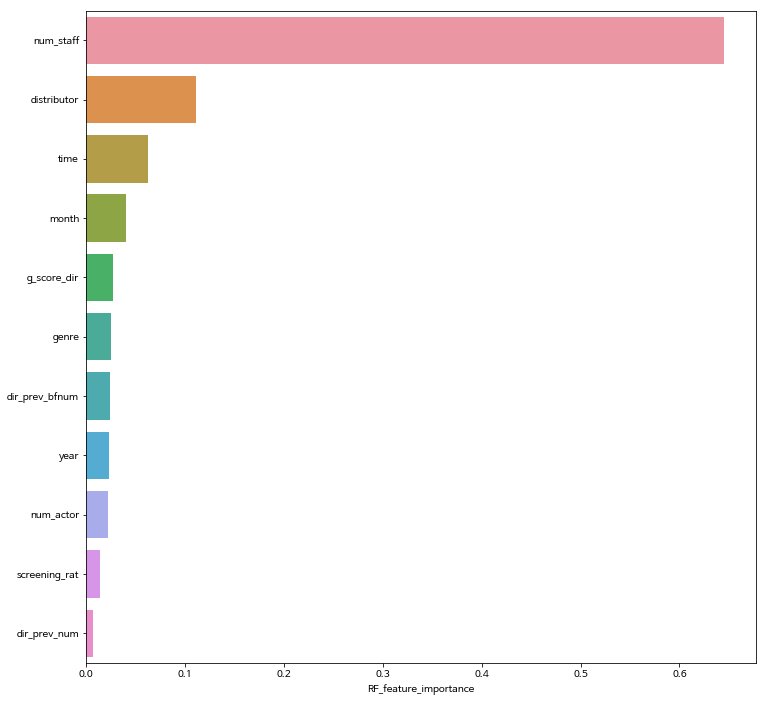

In [96]:
# plot feature importance
feature_importance_rf = pd.DataFrame(data=rf_model.feature_importances_, index=train_data.columns, columns=['RF_feature_importance'])
feature_importance_rf = feature_importance_rf.sort_values(by='RF_feature_importance', ascending=False)
fig = plt.figure(figsize=(12,12))
sns.barplot(data=feature_importance_rf, x='RF_feature_importance', y=feature_importance_rf.index)

### 3.6 ElasticNet

In [97]:
# hyperparameter
el_alphas = np.linspace(0, 3, 100)
# train data
ela_model = ElasticNetCV(alphas=el_alphas, cv=kfolds, l1_ratio=0.2, max_iter=10000).fit(train_data, train_label)

In [98]:
print(cv_rmse(ela_model).mean())

2.022247817871385


### 3.7 Multi-layer Perceptron(Keras)

In [99]:
from keras import models
from keras import layers
from keras import optimizers
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import keras.backend as K

Using TensorFlow backend.


In [100]:
# 먼저 모델링 전 신경망이 잘 학습할 수 있도록 정규화 시켜주자
x_scaler = StandardScaler().fit(train_data)
y_scaler = StandardScaler().fit(train_label.values.reshape(-1,1))

In [101]:
x_train = x_scaler.transform(train_data)
x_test = x_scaler.transform(test_data)
y_train = y_scaler.transform(train_label.values.reshape(-1,1))

In [102]:
x_train.shape, x_test.shape, y_train.shape

((599, 11), (243, 11), (599, 1))

In [103]:
#  root mean squared error를 평가 메트릭으로 사용하기위해 함수를 정의
def root_mean_squared_error(y_pred, y_true):
    squared_err = K.sum(K.square(y_pred - y_true), axis=0)
    mse = K.mean(squared_err)
    return K.sqrt(mse)

In [104]:
# 모델링
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(5, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(1))
    
    optimizer = optimizers.Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse', root_mean_squared_error])
    
    return model

In [105]:
# hyperparameters
epoch = 200
patient = 20
k  = 5
folds = KFold(n_splits=k, shuffle=True, random_state=2019)

In [106]:
import os
model_path = '../model'

if not os.path.exists(model_path):
    os.mkdir(model_path)
    
model_name = os.path.join(model_path, 'adam_model.h5')

In [107]:
callbacks = [
    EarlyStopping(monitor='mse', patience=patient, mode='min', verbose=1),
    ModelCheckpoint(model_name, monitor='mse', verbose=1, save_best_only=True, mode='min'),
    ReduceLROnPlateau(monitor='mse', factor=0.5, patience=patient/3, mode='min', min_lr=0.000001, verbose=1)
]

In [108]:
# 스태킹 모델링을 위해
oof_percep = np.zeros(len(x_train))
prediction_percep = np.zeros(len(x_test))

for folds_, (trn_idx, val_idx) in enumerate(folds.split(train_data)):
    # 처리중인 폴드
    print('처리중인 폴드 :', folds_)
    
    # 훈련 데이터 세트
    trn_data = x_train[trn_idx]
    trn_target = y_train[trn_idx]
    
    # 검증 데이터 세트
    val_data = x_train[val_idx]
    val_target = y_train[val_idx]
    
    model = build_model()
    history = model.fit(
        trn_data,
        trn_target,
        validation_data = (val_data, val_target),
        epochs = epoch,
        batch_size = 10,
        callbacks = callbacks
    )
    
    oof_percep[val_idx] = model.predict(val_data).squeeze()
    prediction_percep += model.predict(x_test).squeeze() / folds.n_splits

처리중인 폴드 : 0
Train on 479 samples, validate on 120 samples
Epoch 1/200
479/479 [==============================] - 0s 571us/step - loss: 1.8658 - mean_squared_error: 1.8658 - root_mean_squared_error: 4.2187 - val_loss: 1.7914 - val_mean_squared_error: 1.7914 - val_root_mean_squared_error: 4.1289
Epoch 2/200
479/479 [==============================] - 0s 114us/step - loss: 1.3356 - mean_squared_error: 1.3356 - root_mean_squared_error: 3.5591 - val_loss: 1.4156 - val_mean_squared_error: 1.4156 - val_root_mean_squared_error: 3.6792
Epoch 3/200
479/479 [==============================] - 0s 114us/step - loss: 1.0656 - mean_squared_error: 1.0656 - root_mean_squared_error: 3.2148 - val_loss: 1.1798 - val_mean_squared_error: 1.1798 - val_root_mean_squared_error: 3.3576
Epoch 4/200
479/479 [==============================] - 0s 114us/step - loss: 0.9115 - mean_squared_error: 0.9115 - root_mean_squared_error: 2.9580 - val_loss: 1.0194 - val_mean_squared_error: 1.0194 - val_root_mean_squared_error: 3

479/479 [==============================] - 0s 112us/step - loss: 0.3565 - mean_squared_error: 0.3565 - root_mean_squared_error: 1.8219 - val_loss: 0.4046 - val_mean_squared_error: 0.4046 - val_root_mean_squared_error: 1.9862
Epoch 36/200
479/479 [==============================] - 0s 103us/step - loss: 0.3553 - mean_squared_error: 0.3553 - root_mean_squared_error: 1.8419 - val_loss: 0.3999 - val_mean_squared_error: 0.3999 - val_root_mean_squared_error: 1.9742
Epoch 37/200
479/479 [==============================] - 0s 103us/step - loss: 0.3520 - mean_squared_error: 0.3520 - root_mean_squared_error: 1.8238 - val_loss: 0.3977 - val_mean_squared_error: 0.3977 - val_root_mean_squared_error: 1.9689
Epoch 38/200
479/479 [==============================] - 0s 95us/step - loss: 0.3509 - mean_squared_error: 0.3509 - root_mean_squared_error: 1.8100 - val_loss: 0.3923 - val_mean_squared_error: 0.3923 - val_root_mean_squared_error: 1.9559
Epoch 39/200
479/479 [==============================] - 0s 93u

479/479 [==============================] - 0s 101us/step - loss: 0.2939 - mean_squared_error: 0.2939 - root_mean_squared_error: 1.6712 - val_loss: 0.3283 - val_mean_squared_error: 0.3283 - val_root_mean_squared_error: 1.7822
Epoch 70/200
479/479 [==============================] - 0s 133us/step - loss: 0.2953 - mean_squared_error: 0.2953 - root_mean_squared_error: 1.6774 - val_loss: 0.3261 - val_mean_squared_error: 0.3261 - val_root_mean_squared_error: 1.7758
Epoch 71/200
479/479 [==============================] - 0s 98us/step - loss: 0.2912 - mean_squared_error: 0.2912 - root_mean_squared_error: 1.6568 - val_loss: 0.3248 - val_mean_squared_error: 0.3248 - val_root_mean_squared_error: 1.7716
Epoch 72/200
479/479 [==============================] - 0s 96us/step - loss: 0.2905 - mean_squared_error: 0.2905 - root_mean_squared_error: 1.6344 - val_loss: 0.3231 - val_mean_squared_error: 0.3231 - val_root_mean_squared_error: 1.7675
Epoch 73/200
479/479 [==============================] - 0s 96us

479/479 [==============================] - 0s 116us/step - loss: 0.2733 - mean_squared_error: 0.2733 - root_mean_squared_error: 1.6035 - val_loss: 0.3047 - val_mean_squared_error: 0.3047 - val_root_mean_squared_error: 1.7124
Epoch 104/200
479/479 [==============================] - 0s 106us/step - loss: 0.2740 - mean_squared_error: 0.2740 - root_mean_squared_error: 1.5986 - val_loss: 0.3093 - val_mean_squared_error: 0.3093 - val_root_mean_squared_error: 1.7263
Epoch 105/200
479/479 [==============================] - 0s 104us/step - loss: 0.2734 - mean_squared_error: 0.2734 - root_mean_squared_error: 1.6065 - val_loss: 0.3060 - val_mean_squared_error: 0.3060 - val_root_mean_squared_error: 1.7169
Epoch 106/200
479/479 [==============================] - 0s 101us/step - loss: 0.2733 - mean_squared_error: 0.2733 - root_mean_squared_error: 1.6030 - val_loss: 0.3062 - val_mean_squared_error: 0.3062 - val_root_mean_squared_error: 1.7161
Epoch 107/200
479/479 [==============================] - 0

479/479 [==============================] - 0s 96us/step - loss: 0.2657 - mean_squared_error: 0.2657 - root_mean_squared_error: 1.5911 - val_loss: 0.3002 - val_mean_squared_error: 0.3002 - val_root_mean_squared_error: 1.6949
Epoch 138/200
479/479 [==============================] - 0s 93us/step - loss: 0.2669 - mean_squared_error: 0.2669 - root_mean_squared_error: 1.5926 - val_loss: 0.2987 - val_mean_squared_error: 0.2987 - val_root_mean_squared_error: 1.6907
Epoch 139/200
479/479 [==============================] - 0s 94us/step - loss: 0.2654 - mean_squared_error: 0.2654 - root_mean_squared_error: 1.5918 - val_loss: 0.3010 - val_mean_squared_error: 0.3010 - val_root_mean_squared_error: 1.6976
Epoch 140/200
479/479 [==============================] - 0s 147us/step - loss: 0.2682 - mean_squared_error: 0.2682 - root_mean_squared_error: 1.5892 - val_loss: 0.3002 - val_mean_squared_error: 0.3002 - val_root_mean_squared_error: 1.6944
Epoch 141/200
479/479 [==============================] - 0s 1

479/479 [==============================] - 0s 112us/step - loss: 0.2611 - mean_squared_error: 0.2611 - root_mean_squared_error: 1.5651 - val_loss: 0.2970 - val_mean_squared_error: 0.2970 - val_root_mean_squared_error: 1.6832
Epoch 172/200
479/479 [==============================] - 0s 115us/step - loss: 0.2615 - mean_squared_error: 0.2615 - root_mean_squared_error: 1.5523 - val_loss: 0.2984 - val_mean_squared_error: 0.2984 - val_root_mean_squared_error: 1.6861
Epoch 173/200
479/479 [==============================] - 0s 115us/step - loss: 0.2605 - mean_squared_error: 0.2605 - root_mean_squared_error: 1.5551 - val_loss: 0.2960 - val_mean_squared_error: 0.2960 - val_root_mean_squared_error: 1.6802
Epoch 174/200
479/479 [==============================] - 0s 107us/step - loss: 0.2608 - mean_squared_error: 0.2608 - root_mean_squared_error: 1.5685 - val_loss: 0.2988 - val_mean_squared_error: 0.2988 - val_root_mean_squared_error: 1.6880
Epoch 175/200
479/479 [==============================] - 0

479/479 [==============================] - 0s 101us/step - loss: 1.0338 - mean_squared_error: 1.0338 - root_mean_squared_error: 3.1469 - val_loss: 0.7972 - val_mean_squared_error: 0.7972 - val_root_mean_squared_error: 2.7286
Epoch 6/200
479/479 [==============================] - 0s 102us/step - loss: 0.8858 - mean_squared_error: 0.8858 - root_mean_squared_error: 2.9146 - val_loss: 0.7181 - val_mean_squared_error: 0.7181 - val_root_mean_squared_error: 2.5962
Epoch 7/200
479/479 [==============================] - 0s 97us/step - loss: 0.7891 - mean_squared_error: 0.7891 - root_mean_squared_error: 2.7524 - val_loss: 0.6726 - val_mean_squared_error: 0.6726 - val_root_mean_squared_error: 2.5116
Epoch 8/200
479/479 [==============================] - 0s 96us/step - loss: 0.7293 - mean_squared_error: 0.7293 - root_mean_squared_error: 2.6431 - val_loss: 0.6386 - val_mean_squared_error: 0.6386 - val_root_mean_squared_error: 2.4435
Epoch 9/200
479/479 [==============================] - 0s 95us/ste

Epoch 40/200
479/479 [==============================] - 0s 268us/step - loss: 0.3593 - mean_squared_error: 0.3593 - root_mean_squared_error: 1.8616 - val_loss: 0.3102 - val_mean_squared_error: 0.3102 - val_root_mean_squared_error: 1.6921
Epoch 41/200
479/479 [==============================] - 0s 176us/step - loss: 0.3563 - mean_squared_error: 0.3563 - root_mean_squared_error: 1.8360 - val_loss: 0.3075 - val_mean_squared_error: 0.3075 - val_root_mean_squared_error: 1.6837
Epoch 42/200
479/479 [==============================] - 0s 136us/step - loss: 0.3529 - mean_squared_error: 0.3529 - root_mean_squared_error: 1.7964 - val_loss: 0.3024 - val_mean_squared_error: 0.3024 - val_root_mean_squared_error: 1.6700
Epoch 43/200
479/479 [==============================] - 0s 130us/step - loss: 0.3499 - mean_squared_error: 0.3499 - root_mean_squared_error: 1.8075 - val_loss: 0.3001 - val_mean_squared_error: 0.3001 - val_root_mean_squared_error: 1.6644
Epoch 44/200
479/479 [==========================

479/479 [==============================] - 0s 94us/step - loss: 0.2908 - mean_squared_error: 0.2908 - root_mean_squared_error: 1.6492 - val_loss: 0.2587 - val_mean_squared_error: 0.2587 - val_root_mean_squared_error: 1.5444
Epoch 75/200
479/479 [==============================] - 0s 106us/step - loss: 0.2910 - mean_squared_error: 0.2910 - root_mean_squared_error: 1.6334 - val_loss: 0.2597 - val_mean_squared_error: 0.2597 - val_root_mean_squared_error: 1.5503
Epoch 76/200
479/479 [==============================] - 0s 179us/step - loss: 0.2895 - mean_squared_error: 0.2895 - root_mean_squared_error: 1.6293 - val_loss: 0.2568 - val_mean_squared_error: 0.2568 - val_root_mean_squared_error: 1.5385
Epoch 77/200
479/479 [==============================] - 0s 182us/step - loss: 0.2885 - mean_squared_error: 0.2885 - root_mean_squared_error: 1.6301 - val_loss: 0.2569 - val_mean_squared_error: 0.2569 - val_root_mean_squared_error: 1.5405
Epoch 78/200
479/479 [==============================] - 0s 141

479/479 [==============================] - 0s 300us/step - loss: 0.2680 - mean_squared_error: 0.2680 - root_mean_squared_error: 1.5740 - val_loss: 0.2561 - val_mean_squared_error: 0.2561 - val_root_mean_squared_error: 1.5398
Epoch 109/200
479/479 [==============================] - 0s 203us/step - loss: 0.2673 - mean_squared_error: 0.2673 - root_mean_squared_error: 1.5788 - val_loss: 0.2544 - val_mean_squared_error: 0.2544 - val_root_mean_squared_error: 1.5349
Epoch 110/200
479/479 [==============================] - 0s 149us/step - loss: 0.2672 - mean_squared_error: 0.2672 - root_mean_squared_error: 1.5768 - val_loss: 0.2564 - val_mean_squared_error: 0.2564 - val_root_mean_squared_error: 1.5406
Epoch 111/200
479/479 [==============================] - 0s 145us/step - loss: 0.2664 - mean_squared_error: 0.2664 - root_mean_squared_error: 1.5557 - val_loss: 0.2551 - val_mean_squared_error: 0.2551 - val_root_mean_squared_error: 1.5370
Epoch 112/200
479/479 [==============================] - 0

479/479 [==============================] - 0s 134us/step - loss: 0.2552 - mean_squared_error: 0.2552 - root_mean_squared_error: 1.5385 - val_loss: 0.2526 - val_mean_squared_error: 0.2526 - val_root_mean_squared_error: 1.5321
Epoch 143/200
479/479 [==============================] - 0s 154us/step - loss: 0.2536 - mean_squared_error: 0.2536 - root_mean_squared_error: 1.5393 - val_loss: 0.2504 - val_mean_squared_error: 0.2504 - val_root_mean_squared_error: 1.5240
Epoch 144/200
479/479 [==============================] - 0s 113us/step - loss: 0.2534 - mean_squared_error: 0.2534 - root_mean_squared_error: 1.5282 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - val_root_mean_squared_error: 1.5289
Epoch 145/200
479/479 [==============================] - 0s 101us/step - loss: 0.2533 - mean_squared_error: 0.2533 - root_mean_squared_error: 1.5054 - val_loss: 0.2514 - val_mean_squared_error: 0.2514 - val_root_mean_squared_error: 1.5269
Epoch 146/200
479/479 [==============================] - 0

479/479 [==============================] - 0s 96us/step - loss: 0.2439 - mean_squared_error: 0.2439 - root_mean_squared_error: 1.4989 - val_loss: 0.2445 - val_mean_squared_error: 0.2445 - val_root_mean_squared_error: 1.5060
Epoch 177/200
479/479 [==============================] - 0s 94us/step - loss: 0.2445 - mean_squared_error: 0.2445 - root_mean_squared_error: 1.5095 - val_loss: 0.2449 - val_mean_squared_error: 0.2449 - val_root_mean_squared_error: 1.5069
Epoch 178/200
479/479 [==============================] - 0s 114us/step - loss: 0.2433 - mean_squared_error: 0.2433 - root_mean_squared_error: 1.5090 - val_loss: 0.2435 - val_mean_squared_error: 0.2435 - val_root_mean_squared_error: 1.5035
Epoch 179/200
479/479 [==============================] - 0s 88us/step - loss: 0.2430 - mean_squared_error: 0.2430 - root_mean_squared_error: 1.4836 - val_loss: 0.2438 - val_mean_squared_error: 0.2438 - val_root_mean_squared_error: 1.5036
Epoch 180/200
479/479 [==============================] - 0s 9

479/479 [==============================] - 0s 122us/step - loss: 0.7727 - mean_squared_error: 0.7727 - root_mean_squared_error: 2.7321 - val_loss: 0.8072 - val_mean_squared_error: 0.8072 - val_root_mean_squared_error: 2.8161
Epoch 11/200
479/479 [==============================] - 0s 127us/step - loss: 0.7510 - mean_squared_error: 0.7510 - root_mean_squared_error: 2.6898 - val_loss: 0.7878 - val_mean_squared_error: 0.7878 - val_root_mean_squared_error: 2.7811
Epoch 12/200
479/479 [==============================] - 0s 130us/step - loss: 0.7309 - mean_squared_error: 0.7309 - root_mean_squared_error: 2.6519 - val_loss: 0.7665 - val_mean_squared_error: 0.7665 - val_root_mean_squared_error: 2.7402
Epoch 13/200
479/479 [==============================] - 0s 117us/step - loss: 0.7131 - mean_squared_error: 0.7131 - root_mean_squared_error: 2.6329 - val_loss: 0.7459 - val_mean_squared_error: 0.7459 - val_root_mean_squared_error: 2.7001
Epoch 14/200
479/479 [==============================] - 0s 12

479/479 [==============================] - 0s 131us/step - loss: 0.3543 - mean_squared_error: 0.3543 - root_mean_squared_error: 1.8207 - val_loss: 0.3955 - val_mean_squared_error: 0.3955 - val_root_mean_squared_error: 1.9221
Epoch 45/200
479/479 [==============================] - 0s 131us/step - loss: 0.3492 - mean_squared_error: 0.3492 - root_mean_squared_error: 1.8294 - val_loss: 0.3937 - val_mean_squared_error: 0.3937 - val_root_mean_squared_error: 1.9187
Epoch 46/200
479/479 [==============================] - 0s 202us/step - loss: 0.3444 - mean_squared_error: 0.3444 - root_mean_squared_error: 1.8050 - val_loss: 0.3927 - val_mean_squared_error: 0.3927 - val_root_mean_squared_error: 1.9180
Epoch 47/200
479/479 [==============================] - 0s 193us/step - loss: 0.3426 - mean_squared_error: 0.3426 - root_mean_squared_error: 1.8020 - val_loss: 0.3901 - val_mean_squared_error: 0.3901 - val_root_mean_squared_error: 1.9124
Epoch 48/200
479/479 [==============================] - 0s 12

479/479 [==============================] - 0s 120us/step - loss: 0.2802 - mean_squared_error: 0.2802 - root_mean_squared_error: 1.6246 - val_loss: 0.3587 - val_mean_squared_error: 0.3587 - val_root_mean_squared_error: 1.8352
Epoch 79/200
479/479 [==============================] - 0s 113us/step - loss: 0.2796 - mean_squared_error: 0.2796 - root_mean_squared_error: 1.6186 - val_loss: 0.3613 - val_mean_squared_error: 0.3613 - val_root_mean_squared_error: 1.8440
Epoch 80/200
479/479 [==============================] - 0s 109us/step - loss: 0.2786 - mean_squared_error: 0.2786 - root_mean_squared_error: 1.6117 - val_loss: 0.3595 - val_mean_squared_error: 0.3595 - val_root_mean_squared_error: 1.8391
Epoch 81/200
479/479 [==============================] - 0s 124us/step - loss: 0.2774 - mean_squared_error: 0.2774 - root_mean_squared_error: 1.6097 - val_loss: 0.3564 - val_mean_squared_error: 0.3564 - val_root_mean_squared_error: 1.8297
Epoch 82/200
479/479 [==============================] - 0s 10

479/479 [==============================] - 0s 144us/step - loss: 0.2634 - mean_squared_error: 0.2634 - root_mean_squared_error: 1.5595 - val_loss: 0.3472 - val_mean_squared_error: 0.3472 - val_root_mean_squared_error: 1.8003
Epoch 113/200
479/479 [==============================] - 0s 120us/step - loss: 0.2637 - mean_squared_error: 0.2637 - root_mean_squared_error: 1.5801 - val_loss: 0.3543 - val_mean_squared_error: 0.3543 - val_root_mean_squared_error: 1.8234
Epoch 114/200
479/479 [==============================] - 0s 130us/step - loss: 0.2636 - mean_squared_error: 0.2636 - root_mean_squared_error: 1.5748 - val_loss: 0.3539 - val_mean_squared_error: 0.3539 - val_root_mean_squared_error: 1.8223
Epoch 115/200
479/479 [==============================] - 0s 154us/step - loss: 0.2620 - mean_squared_error: 0.2620 - root_mean_squared_error: 1.5370 - val_loss: 0.3504 - val_mean_squared_error: 0.3504 - val_root_mean_squared_error: 1.8108
Epoch 116/200
479/479 [==============================] - 0

479/479 [==============================] - 0s 110us/step - loss: 0.2516 - mean_squared_error: 0.2516 - root_mean_squared_error: 1.5361 - val_loss: 0.3536 - val_mean_squared_error: 0.3536 - val_root_mean_squared_error: 1.8198
Epoch 147/200
479/479 [==============================] - 0s 121us/step - loss: 0.2515 - mean_squared_error: 0.2515 - root_mean_squared_error: 1.5271 - val_loss: 0.3562 - val_mean_squared_error: 0.3562 - val_root_mean_squared_error: 1.8276
Epoch 148/200
479/479 [==============================] - 0s 95us/step - loss: 0.2503 - mean_squared_error: 0.2503 - root_mean_squared_error: 1.5267 - val_loss: 0.3497 - val_mean_squared_error: 0.3497 - val_root_mean_squared_error: 1.8061
Epoch 149/200
479/479 [==============================] - 0s 96us/step - loss: 0.2502 - mean_squared_error: 0.2502 - root_mean_squared_error: 1.5356 - val_loss: 0.3515 - val_mean_squared_error: 0.3515 - val_root_mean_squared_error: 1.8134
Epoch 150/200
479/479 [==============================] - 0s 

479/479 [==============================] - 0s 112us/step - loss: 0.2393 - mean_squared_error: 0.2393 - root_mean_squared_error: 1.4793 - val_loss: 0.3723 - val_mean_squared_error: 0.3723 - val_root_mean_squared_error: 1.8641
Epoch 181/200
479/479 [==============================] - 0s 146us/step - loss: 0.2395 - mean_squared_error: 0.2395 - root_mean_squared_error: 1.4974 - val_loss: 0.3701 - val_mean_squared_error: 0.3701 - val_root_mean_squared_error: 1.8593
Epoch 182/200
479/479 [==============================] - 0s 116us/step - loss: 0.2396 - mean_squared_error: 0.2396 - root_mean_squared_error: 1.4854 - val_loss: 0.3702 - val_mean_squared_error: 0.3702 - val_root_mean_squared_error: 1.8598
Epoch 183/200
479/479 [==============================] - 0s 155us/step - loss: 0.2388 - mean_squared_error: 0.2388 - root_mean_squared_error: 1.4914 - val_loss: 0.3771 - val_mean_squared_error: 0.3771 - val_root_mean_squared_error: 1.8791
Epoch 184/200
479/479 [==============================] - 0

479/479 [==============================] - 0s 171us/step - loss: 0.4631 - mean_squared_error: 0.4631 - root_mean_squared_error: 2.0944 - val_loss: 0.4224 - val_mean_squared_error: 0.4224 - val_root_mean_squared_error: 1.9765
Epoch 15/200
479/479 [==============================] - 0s 190us/step - loss: 0.4495 - mean_squared_error: 0.4495 - root_mean_squared_error: 2.0583 - val_loss: 0.4161 - val_mean_squared_error: 0.4161 - val_root_mean_squared_error: 1.9596
Epoch 16/200
479/479 [==============================] - 0s 147us/step - loss: 0.4376 - mean_squared_error: 0.4376 - root_mean_squared_error: 2.0421 - val_loss: 0.4091 - val_mean_squared_error: 0.4091 - val_root_mean_squared_error: 1.9419
Epoch 17/200
479/479 [==============================] - 0s 158us/step - loss: 0.4281 - mean_squared_error: 0.4281 - root_mean_squared_error: 2.0065 - val_loss: 0.4044 - val_mean_squared_error: 0.4044 - val_root_mean_squared_error: 1.9298
Epoch 18/200
479/479 [==============================] - 0s 14

479/479 [==============================] - 0s 105us/step - loss: 0.3003 - mean_squared_error: 0.3003 - root_mean_squared_error: 1.6830 - val_loss: 0.3228 - val_mean_squared_error: 0.3228 - val_root_mean_squared_error: 1.7441
Epoch 49/200
479/479 [==============================] - 0s 111us/step - loss: 0.2989 - mean_squared_error: 0.2989 - root_mean_squared_error: 1.6827 - val_loss: 0.3217 - val_mean_squared_error: 0.3217 - val_root_mean_squared_error: 1.7404
Epoch 50/200
479/479 [==============================] - 0s 149us/step - loss: 0.2981 - mean_squared_error: 0.2981 - root_mean_squared_error: 1.6746 - val_loss: 0.3200 - val_mean_squared_error: 0.3200 - val_root_mean_squared_error: 1.7380
Epoch 51/200
479/479 [==============================] - 0s 144us/step - loss: 0.2968 - mean_squared_error: 0.2968 - root_mean_squared_error: 1.6691 - val_loss: 0.3209 - val_mean_squared_error: 0.3209 - val_root_mean_squared_error: 1.7366
Epoch 52/200
479/479 [==============================] - 0s 15

479/479 [==============================] - 0s 130us/step - loss: 0.2671 - mean_squared_error: 0.2671 - root_mean_squared_error: 1.5913 - val_loss: 0.2976 - val_mean_squared_error: 0.2976 - val_root_mean_squared_error: 1.6876
Epoch 83/200
479/479 [==============================] - 0s 124us/step - loss: 0.2676 - mean_squared_error: 0.2676 - root_mean_squared_error: 1.5868 - val_loss: 0.2979 - val_mean_squared_error: 0.2979 - val_root_mean_squared_error: 1.6884
Epoch 84/200
479/479 [==============================] - 0s 140us/step - loss: 0.2662 - mean_squared_error: 0.2662 - root_mean_squared_error: 1.5734 - val_loss: 0.2970 - val_mean_squared_error: 0.2970 - val_root_mean_squared_error: 1.6870
Epoch 85/200
479/479 [==============================] - 0s 162us/step - loss: 0.2657 - mean_squared_error: 0.2657 - root_mean_squared_error: 1.5712 - val_loss: 0.2972 - val_mean_squared_error: 0.2972 - val_root_mean_squared_error: 1.6866
Epoch 86/200
479/479 [==============================] - 0s 18

479/479 [==============================] - 0s 184us/step - loss: 0.2527 - mean_squared_error: 0.2527 - root_mean_squared_error: 1.5343 - val_loss: 0.2901 - val_mean_squared_error: 0.2901 - val_root_mean_squared_error: 1.6715
Epoch 117/200
479/479 [==============================] - 0s 280us/step - loss: 0.2511 - mean_squared_error: 0.2511 - root_mean_squared_error: 1.5496 - val_loss: 0.2894 - val_mean_squared_error: 0.2894 - val_root_mean_squared_error: 1.6648
Epoch 118/200
479/479 [==============================] - 0s 226us/step - loss: 0.2499 - mean_squared_error: 0.2499 - root_mean_squared_error: 1.5391 - val_loss: 0.2895 - val_mean_squared_error: 0.2895 - val_root_mean_squared_error: 1.6672
Epoch 119/200
479/479 [==============================] - 0s 158us/step - loss: 0.2500 - mean_squared_error: 0.2500 - root_mean_squared_error: 1.5278 - val_loss: 0.2903 - val_mean_squared_error: 0.2903 - val_root_mean_squared_error: 1.6700
Epoch 120/200
479/479 [==============================] - 0

479/479 [==============================] - 0s 130us/step - loss: 0.2430 - mean_squared_error: 0.2430 - root_mean_squared_error: 1.5069 - val_loss: 0.2906 - val_mean_squared_error: 0.2906 - val_root_mean_squared_error: 1.6706
Epoch 151/200
479/479 [==============================] - 0s 129us/step - loss: 0.2426 - mean_squared_error: 0.2426 - root_mean_squared_error: 1.5021 - val_loss: 0.2906 - val_mean_squared_error: 0.2906 - val_root_mean_squared_error: 1.6699
Epoch 152/200
479/479 [==============================] - 0s 127us/step - loss: 0.2433 - mean_squared_error: 0.2433 - root_mean_squared_error: 1.5063 - val_loss: 0.2905 - val_mean_squared_error: 0.2905 - val_root_mean_squared_error: 1.6711
Epoch 153/200
479/479 [==============================] - 0s 113us/step - loss: 0.2429 - mean_squared_error: 0.2429 - root_mean_squared_error: 1.4981 - val_loss: 0.2907 - val_mean_squared_error: 0.2907 - val_root_mean_squared_error: 1.6710
Epoch 154/200
479/479 [==============================] - 0

479/479 [==============================] - 0s 222us/step - loss: 0.2384 - mean_squared_error: 0.2384 - root_mean_squared_error: 1.4941 - val_loss: 0.2977 - val_mean_squared_error: 0.2977 - val_root_mean_squared_error: 1.6913
Epoch 185/200
479/479 [==============================] - 0s 143us/step - loss: 0.2385 - mean_squared_error: 0.2385 - root_mean_squared_error: 1.5034 - val_loss: 0.2996 - val_mean_squared_error: 0.2996 - val_root_mean_squared_error: 1.6989
Epoch 186/200
479/479 [==============================] - ETA: 0s - loss: 0.2345 - mean_squared_error: 0.2345 - root_mean_squared_error: 1.48 - 0s 161us/step - loss: 0.2380 - mean_squared_error: 0.2380 - root_mean_squared_error: 1.4925 - val_loss: 0.2993 - val_mean_squared_error: 0.2993 - val_root_mean_squared_error: 1.6964
Epoch 187/200
479/479 [==============================] - 0s 152us/step - loss: 0.2389 - mean_squared_error: 0.2389 - root_mean_squared_error: 1.4978 - val_loss: 0.2980 - val_mean_squared_error: 0.2980 - val_root

Epoch 18/200
480/480 [==============================] - 0s 120us/step - loss: 0.6214 - mean_squared_error: 0.6214 - root_mean_squared_error: 2.4579 - val_loss: 0.7801 - val_mean_squared_error: 0.7801 - val_root_mean_squared_error: 2.7080
Epoch 19/200
480/480 [==============================] - 0s 107us/step - loss: 0.6029 - mean_squared_error: 0.6029 - root_mean_squared_error: 2.4026 - val_loss: 0.7625 - val_mean_squared_error: 0.7625 - val_root_mean_squared_error: 2.6765
Epoch 20/200
480/480 [==============================] - 0s 108us/step - loss: 0.5853 - mean_squared_error: 0.5853 - root_mean_squared_error: 2.3672 - val_loss: 0.7338 - val_mean_squared_error: 0.7338 - val_root_mean_squared_error: 2.6261
Epoch 21/200
480/480 [==============================] - 0s 212us/step - loss: 0.5688 - mean_squared_error: 0.5688 - root_mean_squared_error: 2.3262 - val_loss: 0.7108 - val_mean_squared_error: 0.7108 - val_root_mean_squared_error: 2.5833
Epoch 22/200
480/480 [==========================

480/480 [==============================] - 0s 108us/step - loss: 0.3426 - mean_squared_error: 0.3426 - root_mean_squared_error: 1.8081 - val_loss: 0.3945 - val_mean_squared_error: 0.3945 - val_root_mean_squared_error: 1.8896
Epoch 53/200
480/480 [==============================] - 0s 107us/step - loss: 0.3401 - mean_squared_error: 0.3401 - root_mean_squared_error: 1.7988 - val_loss: 0.3923 - val_mean_squared_error: 0.3923 - val_root_mean_squared_error: 1.8842
Epoch 54/200
480/480 [==============================] - 0s 100us/step - loss: 0.3371 - mean_squared_error: 0.3371 - root_mean_squared_error: 1.7999 - val_loss: 0.3910 - val_mean_squared_error: 0.3910 - val_root_mean_squared_error: 1.8818
Epoch 55/200
480/480 [==============================] - 0s 99us/step - loss: 0.3346 - mean_squared_error: 0.3346 - root_mean_squared_error: 1.7868 - val_loss: 0.3884 - val_mean_squared_error: 0.3884 - val_root_mean_squared_error: 1.8752
Epoch 56/200
480/480 [==============================] - 0s 101

480/480 [==============================] - 0s 99us/step - loss: 0.2922 - mean_squared_error: 0.2922 - root_mean_squared_error: 1.6680 - val_loss: 0.3542 - val_mean_squared_error: 0.3542 - val_root_mean_squared_error: 1.7983
Epoch 87/200
480/480 [==============================] - 0s 101us/step - loss: 0.2910 - mean_squared_error: 0.2910 - root_mean_squared_error: 1.6663 - val_loss: 0.3541 - val_mean_squared_error: 0.3541 - val_root_mean_squared_error: 1.7988
Epoch 88/200
480/480 [==============================] - 0s 107us/step - loss: 0.2901 - mean_squared_error: 0.2901 - root_mean_squared_error: 1.6669 - val_loss: 0.3532 - val_mean_squared_error: 0.3532 - val_root_mean_squared_error: 1.7964
Epoch 89/200
480/480 [==============================] - 0s 101us/step - loss: 0.2906 - mean_squared_error: 0.2906 - root_mean_squared_error: 1.6469 - val_loss: 0.3555 - val_mean_squared_error: 0.3555 - val_root_mean_squared_error: 1.8024
Epoch 90/200
480/480 [==============================] - 0s 102

480/480 [==============================] - 0s 183us/step - loss: 0.2748 - mean_squared_error: 0.2748 - root_mean_squared_error: 1.6113 - val_loss: 0.3507 - val_mean_squared_error: 0.3507 - val_root_mean_squared_error: 1.7915
Epoch 121/200
480/480 [==============================] - 0s 146us/step - loss: 0.2747 - mean_squared_error: 0.2747 - root_mean_squared_error: 1.6051 - val_loss: 0.3472 - val_mean_squared_error: 0.3472 - val_root_mean_squared_error: 1.7826
Epoch 122/200
480/480 [==============================] - 0s 134us/step - loss: 0.2735 - mean_squared_error: 0.2735 - root_mean_squared_error: 1.6049 - val_loss: 0.3476 - val_mean_squared_error: 0.3476 - val_root_mean_squared_error: 1.7836
Epoch 123/200
480/480 [==============================] - 0s 148us/step - loss: 0.2733 - mean_squared_error: 0.2733 - root_mean_squared_error: 1.5990 - val_loss: 0.3458 - val_mean_squared_error: 0.3458 - val_root_mean_squared_error: 1.7802
Epoch 124/200
480/480 [==============================] - 0

480/480 [==============================] - 0s 133us/step - loss: 0.2591 - mean_squared_error: 0.2591 - root_mean_squared_error: 1.5507 - val_loss: 0.3387 - val_mean_squared_error: 0.3387 - val_root_mean_squared_error: 1.7593
Epoch 155/200
480/480 [==============================] - 0s 120us/step - loss: 0.2586 - mean_squared_error: 0.2586 - root_mean_squared_error: 1.5541 - val_loss: 0.3401 - val_mean_squared_error: 0.3401 - val_root_mean_squared_error: 1.7629
Epoch 156/200
480/480 [==============================] - 0s 115us/step - loss: 0.2592 - mean_squared_error: 0.2592 - root_mean_squared_error: 1.5729 - val_loss: 0.3368 - val_mean_squared_error: 0.3368 - val_root_mean_squared_error: 1.7561
Epoch 157/200
480/480 [==============================] - 0s 119us/step - loss: 0.2582 - mean_squared_error: 0.2582 - root_mean_squared_error: 1.5543 - val_loss: 0.3391 - val_mean_squared_error: 0.3391 - val_root_mean_squared_error: 1.7608
Epoch 158/200
480/480 [==============================] - 0

480/480 [==============================] - 0s 111us/step - loss: 0.2460 - mean_squared_error: 0.2460 - root_mean_squared_error: 1.5381 - val_loss: 0.3268 - val_mean_squared_error: 0.3268 - val_root_mean_squared_error: 1.7331
Epoch 189/200
480/480 [==============================] - 0s 108us/step - loss: 0.2455 - mean_squared_error: 0.2455 - root_mean_squared_error: 1.5136 - val_loss: 0.3255 - val_mean_squared_error: 0.3255 - val_root_mean_squared_error: 1.7321
Epoch 190/200
480/480 [==============================] - 0s 126us/step - loss: 0.2449 - mean_squared_error: 0.2449 - root_mean_squared_error: 1.5243 - val_loss: 0.3232 - val_mean_squared_error: 0.3232 - val_root_mean_squared_error: 1.7244
Epoch 191/200
480/480 [==============================] - 0s 114us/step - loss: 0.2459 - mean_squared_error: 0.2459 - root_mean_squared_error: 1.5072 - val_loss: 0.3231 - val_mean_squared_error: 0.3231 - val_root_mean_squared_error: 1.7246
Epoch 192/200
480/480 [==============================] - 0

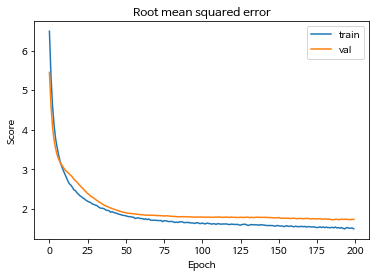

In [109]:
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='val')
plt.title('Root mean squared error')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

In [110]:
# 두 종류의 모델이 필요하다.
# 하나는 지금까지 학습시킨 개별적인 기본모델들이고,
# 다른 하나는 개별 기반 모델의 예측 데이터를 학습데이터로 만들어서 학습하는 최종 메타 모델이다.

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n):
    # KFold는 위에서 만들어진것을 쓴다.
    # 추후에 메타 모델이 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], folds.n_splits))
    print(model.__class__.__name__, ' model 시작')
    
    for folds_, (trn_index, val_index) in enumerate(folds.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print('\t폴드 세트: ', folds_, ' 시작')
        trn_data = X_train_n.iloc[trn_index]
        val_data = X_train_n.iloc[val_index]
        y_trn = y_train_n.iloc[trn_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
        model.fit(trn_data, y_trn)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
        train_fold_pred[val_index,:] = model.predict(val_data).reshape(-1,1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
        test_pred[:, folds_] = model.predict(X_test_n)
        
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1)
    
    # train_fold_predsms 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [111]:
# xgboost와 lightgbm은 각각 oof1,oof2 | predictions, predictions2 로 만들어져 있으니 RandomForest
# ridge_train, ridge_test = get_stacking_base_datasets(ridge_model2, df_train, y_reg, df_test)
rf_train, rf_test = get_stacking_base_datasets(rf_model, train_data, train_label, test_data)
ela_train, ela_test = get_stacking_base_datasets(ela_model, train_data, train_label, test_data)

RandomForestRegressor  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작
ElasticNetCV  model 시작
	폴드 세트:  0  시작
	폴드 세트:  1  시작
	폴드 세트:  2  시작
	폴드 세트:  3  시작
	폴드 세트:  4  시작


In [112]:
inv_oof_percep = y_scaler.inverse_transform(oof_percep)
inv_prediction_percep = y_scaler.inverse_transform(prediction_percep)

In [113]:
from sklearn.linear_model import Ridge

Stack_final_X_train = np.concatenate([inv_oof_percep.reshape(-1,1), rf_train, oof1.reshape(-1,1), oof2.reshape(-1,1)], axis=1)
Stack_final_X_test = np.concatenate([inv_prediction_percep[:,np.newaxis], rf_test[:,np.newaxis], predictions[:,np.newaxis], predictions2[:,np.newaxis]], axis=1)

# 최종 메타 모델은 릿지 모델을 적용
meta_model_ridge = Ridge(alpha=0.1)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측
meta_model_ridge.fit(Stack_final_X_train, train_label)
final = meta_model_ridge.predict(Stack_final_X_test)

In [114]:
stack_preds = np.expm1(final)

In [115]:
submission = pd.read_csv('../submission.csv')
# 제출 : stacked_model
submission['box_off_num'] = stack_preds
submission.to_csv('../output/stacking_model.csv', index=False)

In [116]:
# submission = pd.read_csv('../submission.csv')
# # 제출 : perceptron
# inv_prediction_percep = y_scaler.inverse_transform(prediction_percep)
# submission['box_off_num'] = np.expm1(inv_prediction_percep)
# submission.to_csv('../output/perceptron.csv', index=False)
# # submission

In [117]:
# submission = pd.read_csv('../submission.csv')
# # 제출 : lightgbm
# test_lgb_preds = np.expm1(predictions)
# # print(test_lgb_preds)
# submission['box_off_num'] = test_lgb_preds
# submission.to_csv('../output/lightgbm.csv', index=False)

In [118]:
# submission = pd.read_csv('../submission.csv')
# # 제출 : xgboost
# test_xgb_preds = np.expm1(predictions2)
# submission['box_off_num'] = test_xgb_preds
# submission.to_csv('../output/xgboost.csv', index=False)

In [119]:
# # 제출 : 0.5*ridge + 0.5*lasso
# result1 = lasso_model.predict(test_data)
# result2 = ridge_model.predict(test_data)
# result = 0.5*result1 + 0.5*result2
# result = np.expm1(result)
# submission['box_off_num'] = result
# submission.to_csv('../ridge_lasso_ensemble.csv', index=False)